In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [2]:
def datfile_new(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'/mnt/SBOR/ZCU111/new_firmware/'+filename) as fd:
        i=0
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                formatted_time = time.strftime('%Y-%m-%d %H:%M:%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if i%4==0:
                    recordtime.append(formatted_time)
                i+=1
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

['2024-06-12 06:09:43']


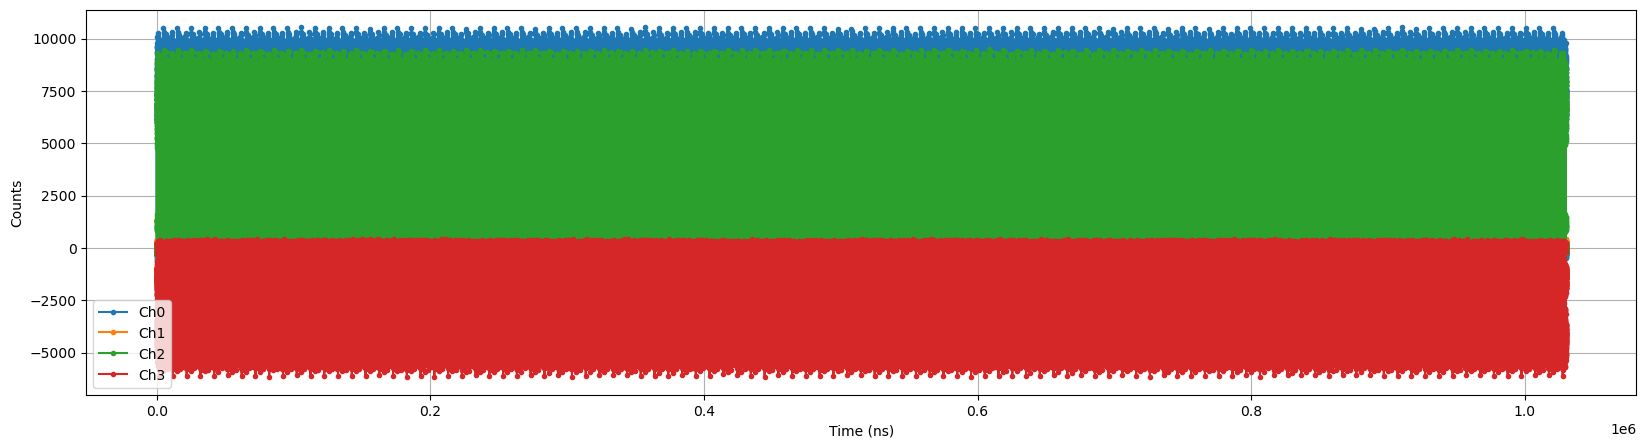

In [3]:
ampFault,recordtime=datfile_new("data_20240612_060846.dat")

print(recordtime)
eventnum=0
size = len(ampFault[0][eventnum])

#print(recordtime[eventnum])
timeBin = 1.0/(0.509) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

index=np.where(ampFault[0][eventnum] > 2000)[0]
# Plot the Waveform Full Scale
plt.figure(figsize=(20,5))
start=4646
plt.plot(timeSteps,ampFault[0][eventnum],label="Ch0",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[2][eventnum],label="Ch2",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[3][eventnum],label="Ch3",marker='o',markersize=3)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
#plt.xlim(0,5000)
plt.legend()
plt.grid()

In [4]:
def periodic_plot(datfile):
    eventnum=0
    ampFault,recordtime=datfile_new(datfile)
    if len(ampFault[0])==0:
        print(datfile)
        #print('invalid data')
        return False

    if max(ampFault[0][eventnum][0:5120])<3000:
        return False
    #print(datfile)
    for i in range(2560):
        if max(ampFault[0][eventnum][i:i+50])<2000:
            start=i+50
            break
    #print(start)

    bunch_index=[]
    for i in range(5120):
        if ampFault[0][eventnum][start+i]>3000:
            bunch_index.append(start+i)
    
    bunch_index=np.array(bunch_index)
    #print(len(bunch_index))
    if len(bunch_index)<2000:
        return False
    
    #print(bunch_index)
    Nturn=(len(ampFault[0][eventnum])-start)//5120
    UV=[]
    DV=[]
    charge_U=[]
    charge_D=[]
    for j in bunch_index:
        certain_bunch_UV=[]
        certain_bunch_DV=[]
        certain_bunch_charge_U=[]
        certain_bunch_charge_D=[]
        for i in range(Nturn):
            tbt_0=ampFault[0][eventnum][j+5120*i]
            tbt_1=ampFault[1][eventnum][j+5120*i]
            tbt_2=ampFault[2][eventnum][j+5120*i]
            tbt_3=ampFault[3][eventnum][j+5120*i]
            certain_bunch_UV.append(tbt_3/tbt_2*(16.58)/5)
            certain_bunch_DV.append(tbt_1/tbt_0*(16.58)/5)
            certain_bunch_charge_U.append(tbt_2)
            certain_bunch_charge_D.append(tbt_0)
        UV.append(np.array(certain_bunch_UV))
        DV.append(np.array(certain_bunch_DV))
        charge_U.append(np.array(certain_bunch_charge_U))
        charge_D.append(np.array(certain_bunch_charge_D))
    UV=np.array(UV)
    DV=np.array(DV)
    charge_U=np.array(charge_U)
    charge_D=np.array(charge_D)
    
    mean=np.mean(UV[:,0:10],axis=1)
    UV=UV-mean[:,np.newaxis]
    mean=np.mean(DV[:,0:10],axis=1)
    DV=DV-mean[:,np.newaxis]
    charge_mean=np.mean(charge_U[:,0:10],axis=1)
    charge_U=charge_U/charge_mean[:,np.newaxis]
    charge_mean=np.mean(charge_D[:,0:10],axis=1)
    charge_D=charge_D/charge_mean[:,np.newaxis]
    
    x_axis_0=[]
    for i in range(Nturn):
        x_axis_0.append(bunch_index-bunch_index[0]+5120*i)
    
    x_axis=np.concatenate(x_axis_0)/0.509


    split=np.hsplit(DV,DV.shape[1])
    pos=np.concatenate(split).flatten()
    data=pd.DataFrame({"x_axis":x_axis,"DV":pos})
    data["MA"]=data["DV"].rolling(window=500).mean()
    threshold = 0.014
    # 閾値を超えた点を特定
    data['above_threshold'] = data['MA'].abs() > threshold
    if data['above_threshold'].any():
        first_above_threshold = data[data['above_threshold']].iloc[0]
        first_above_x = first_above_threshold['x_axis']
        print(datfile)
        print(first_above_x)
        fig2, (ax2) = plt.subplots(1, 1, sharex=True,figsize=(20,3))
        ax2.set_title(f'{recordtime[0]}')
        ax2.scatter(x_axis,np.concatenate(split),color='red',s=1,label='data')
        # 閾値を超えた点を強調
        ax2.scatter(data['x_axis'][data['above_threshold']], data['MA'][data['above_threshold']], color='cyan', label='Above Threshold', zorder=5,s=2)
        ax2.set_ylabel("Y position (mm)")
        ax2.set_ylim(-0.4,0.4)
        ax2.grid()
        #ax2.legend()
        ax2.text(0.02,0.05,'Downstream Vertical',transform=ax2.transAxes,ha='left',va='bottom',fontsize=10)
        ax2.set_xlabel("Time (ns)")
        #plt.savefig("beamloss2.png",dpi=200)
        #plt.xlim(0.90e6,0.92e6)
        plt.subplots_adjust(hspace=.4)
        plt.show()
        """
        waveform=np.concatenate(split)
        segment_length=len(bunch_index)*2
        overlap = len(bunch_index)
        
        # FFTを行うセグメントの数を計算
        num_segments = (len(waveform) - segment_length) // overlap + 1
        
        # FFT結果を格納するリスト
        fft_results = []
        
        for i in range(num_segments):
            start = i * overlap
            end = start + segment_length
            segment = waveform[start:end]
            
            # FFTを実行
            fft_result = np.fft.fft(segment)
            
            # 結果をリストに追加
            fft_results.append(fft_result[:segment_length//2])
        
        # 結果を配列に変換
        fft_results = np.array(fft_results)
        
        # プロット用のデータを準備
        X = np.arange(fft_results.shape[0])
        Y = np.fft.fftfreq(segment_length,1/segment_length)[:segment_length//2]
        X, Y = np.meshgrid(X, Y)
        Z = np.abs(fft_results.T)
        if len(Z)==1:
            plt.figure(figsize=(15,10))
            plt.pcolormesh(Z[0].T,cmap='jet')
            plt.xlabel("Mode")
            plt.colorbar(label='Magnitude')
            plt.show()
        """
        return True
    else:
        return False
        

In [5]:
files = os.listdir("/mnt/SBOR/ZCU111/new_firmware/")
dat_files = [file for file in files if file.endswith('.dat')]

In [6]:
len(dat_files)

12990

data_20240616_033346.dat
885542.2396856581


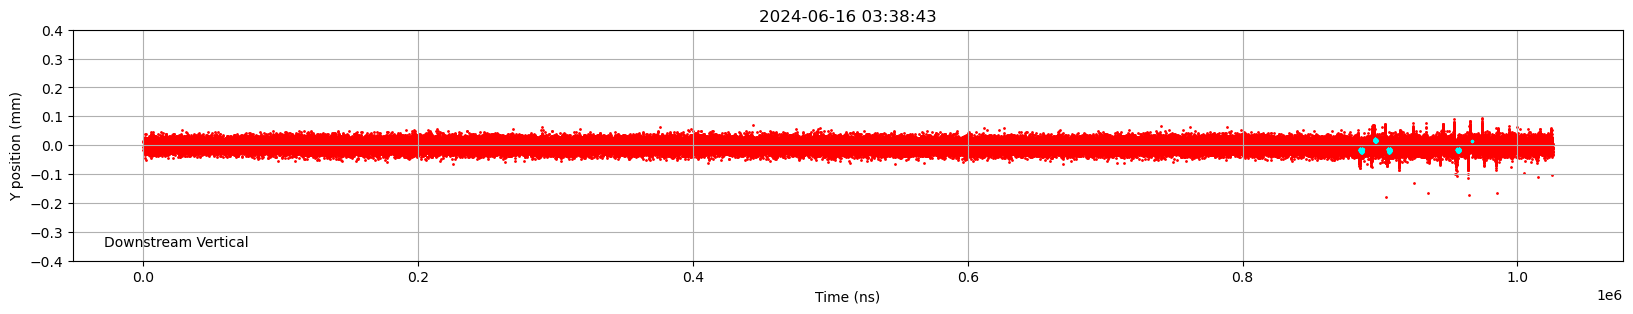

data_20240610_141717.dat
1021013.7524557956


/tmp/ipykernel_2328000/3476755253.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  certain_bunch_DV.append(tbt_1/tbt_0*(16.58)/5)


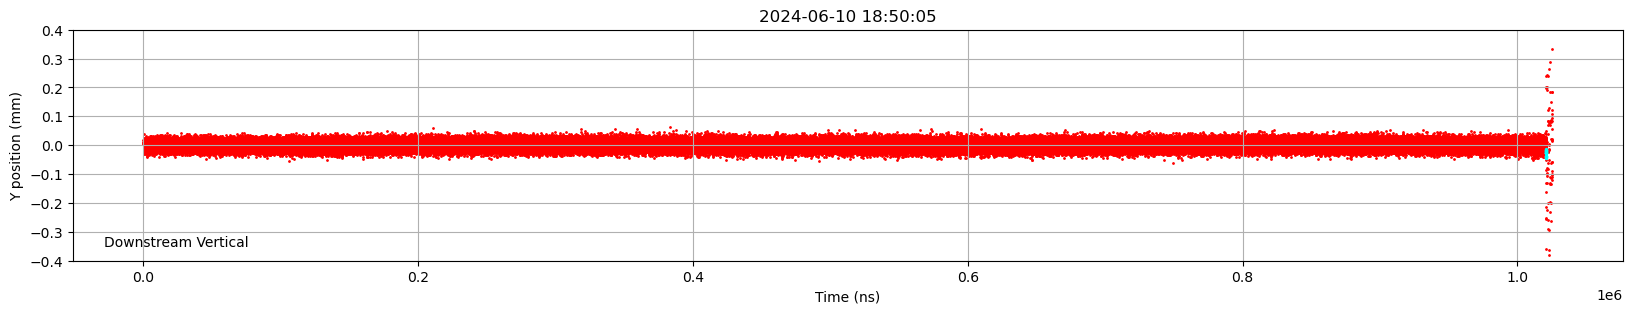

data_20240630_212011.dat
3123.7721021611


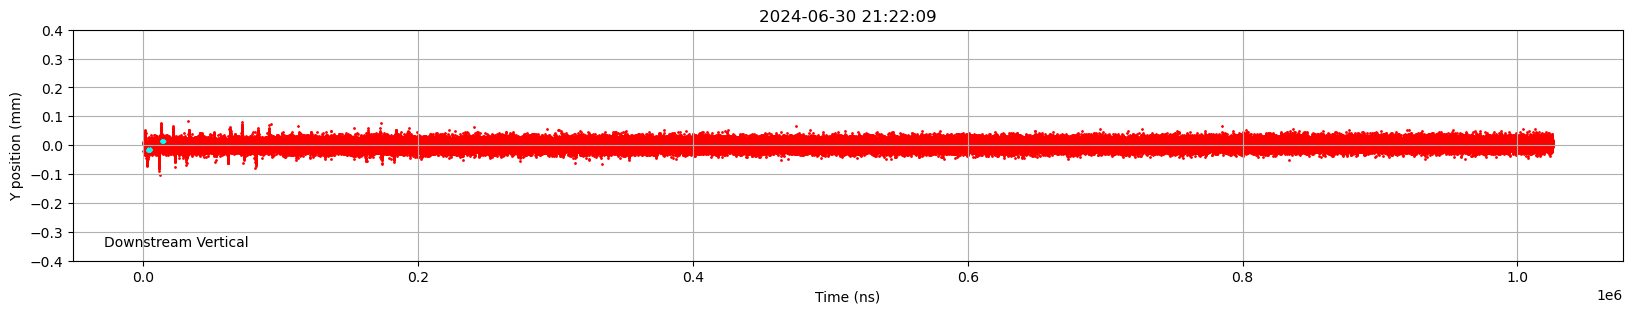

data_20240629_094024.dat
987774.0667976424


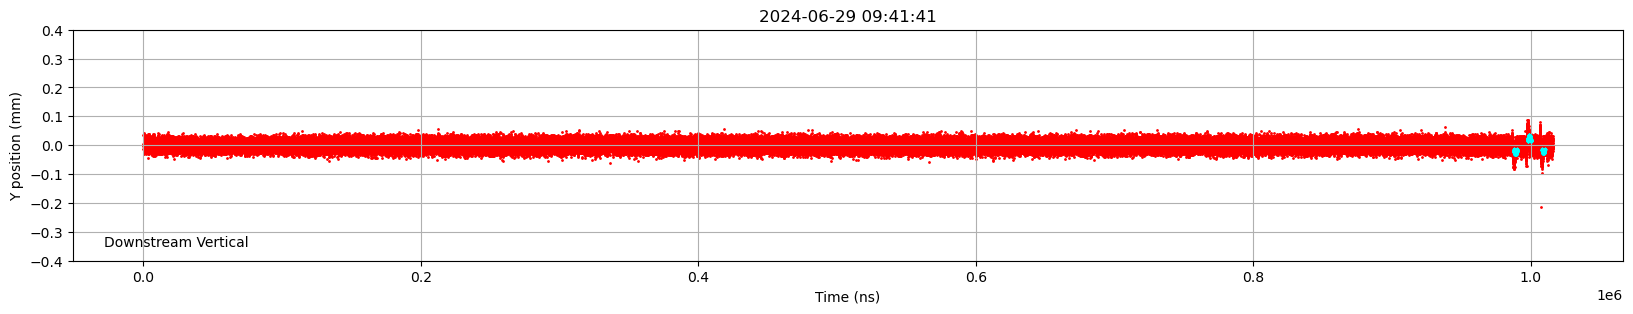

data_20240629_202608.dat
5842.829076620825


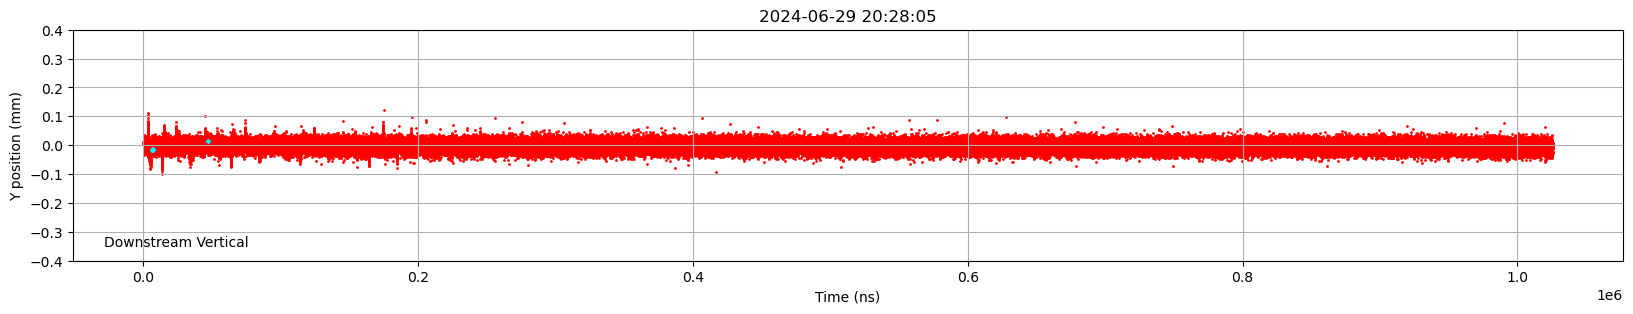

data_20240613_041731.dat
295371.3163064833


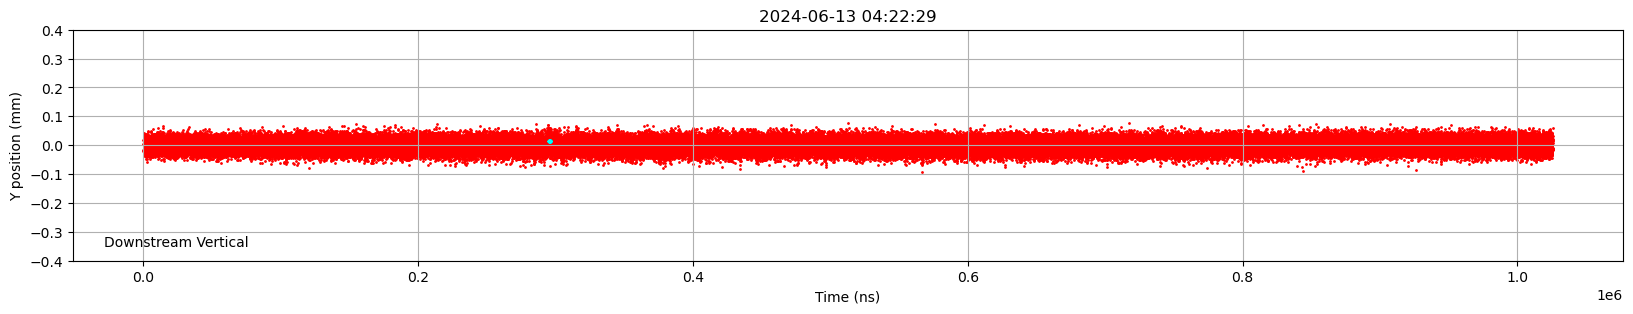

data_20240630_152916.dat
11950.884086444008


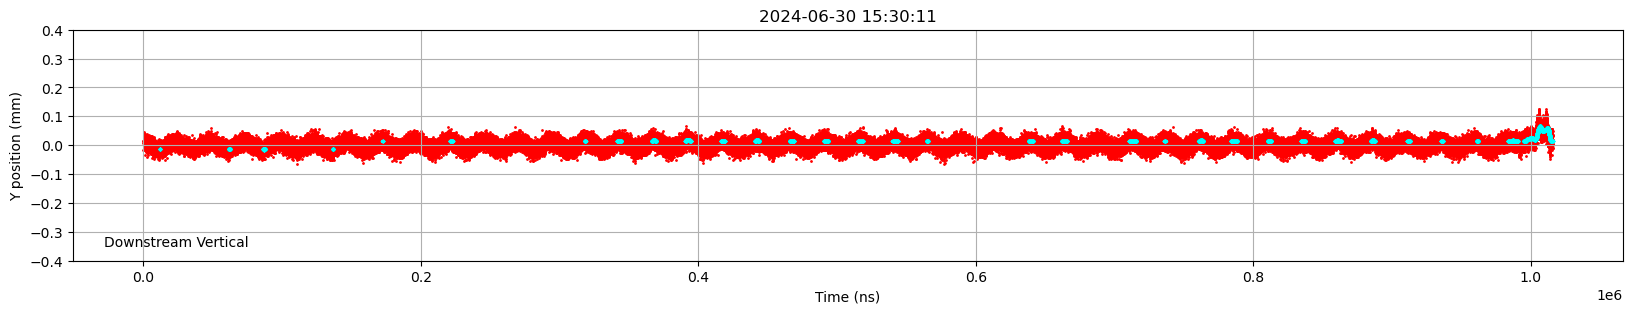

data_20240629_055747.dat
985045.1866404715


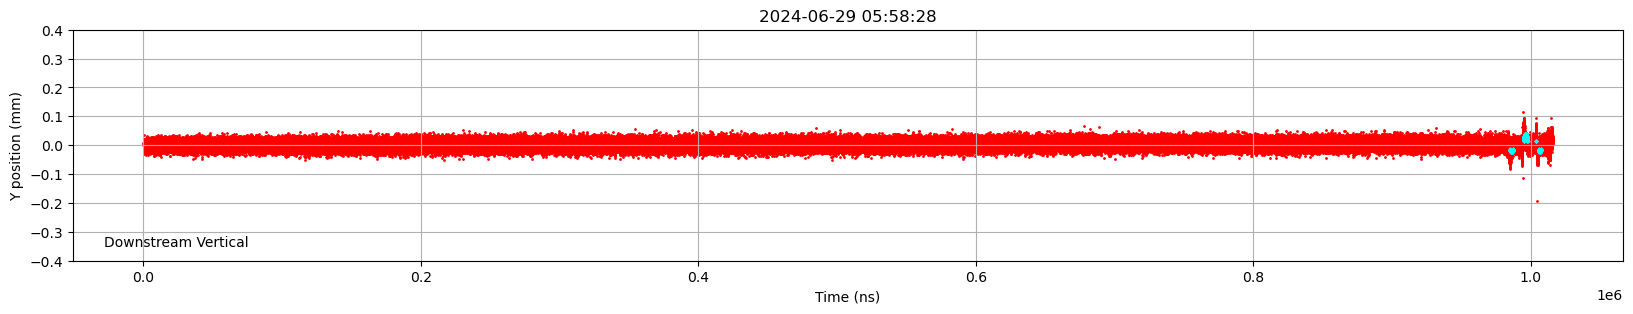

data_20240630_220418.dat
958387.0333988213


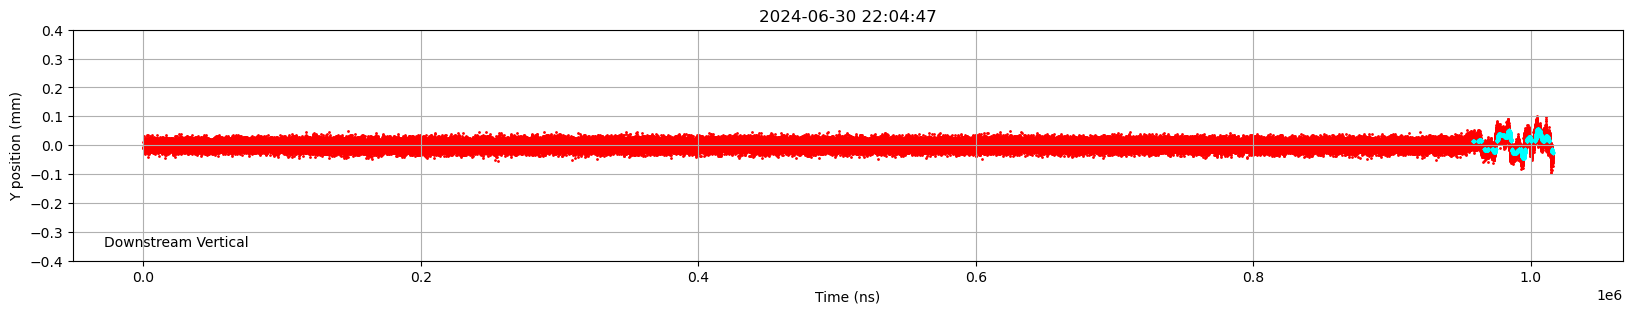

data_20240701_073549.dat
806487.2298624754


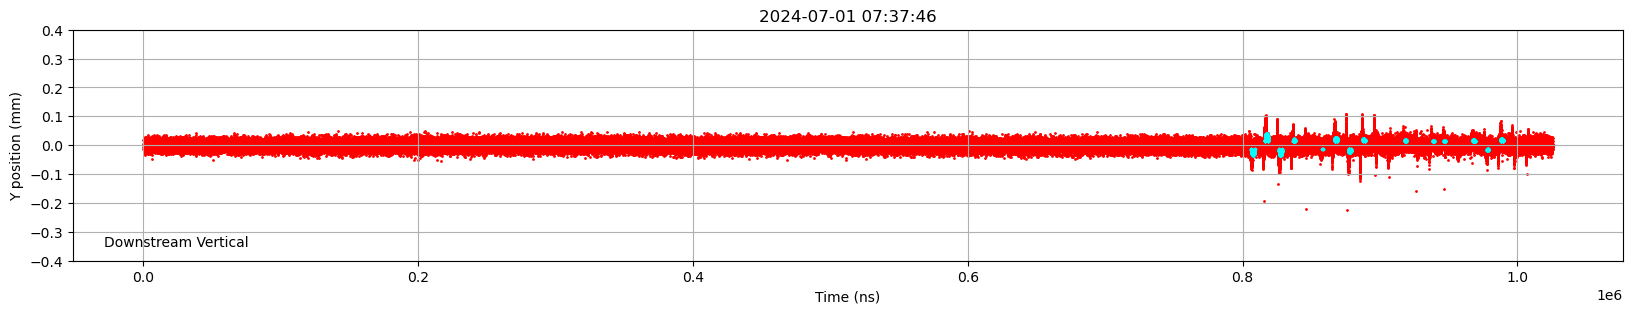

data_20240627_032000.dat
454151.27701375243


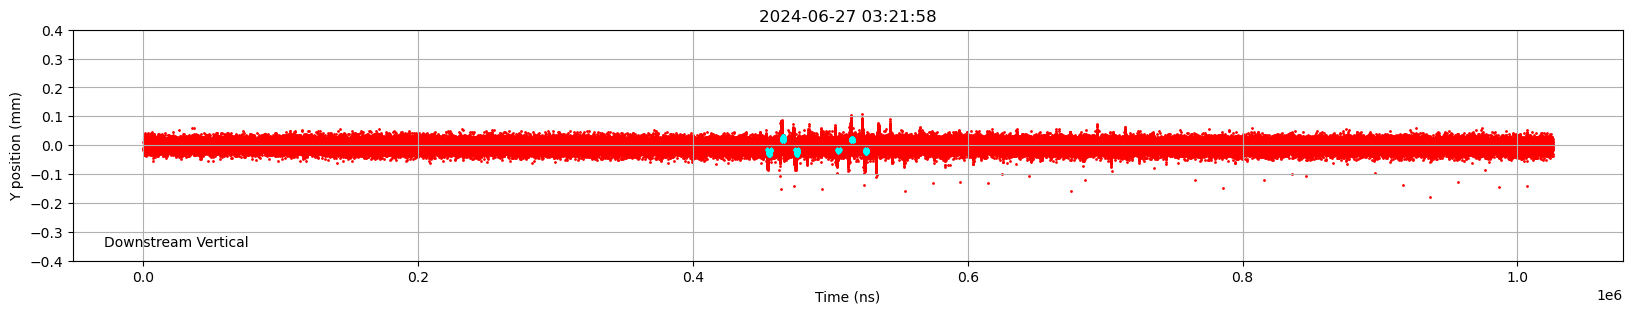

data_20240630_095023.dat
973807.4656188604


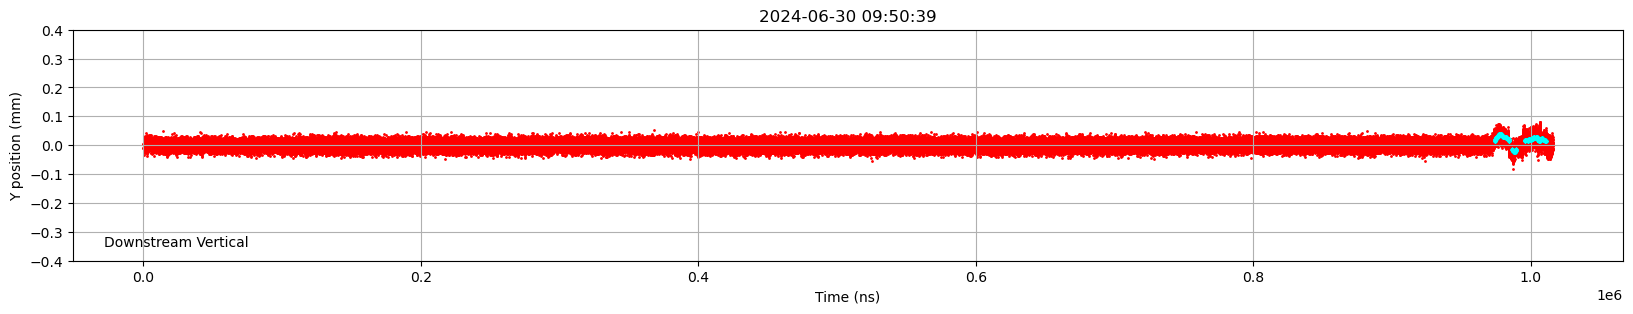

data_20240620_153111.dat
data_20240610_212929.dat
981813.3595284872


/tmp/ipykernel_2328000/3476755253.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  certain_bunch_DV.append(tbt_1/tbt_0*(16.58)/5)


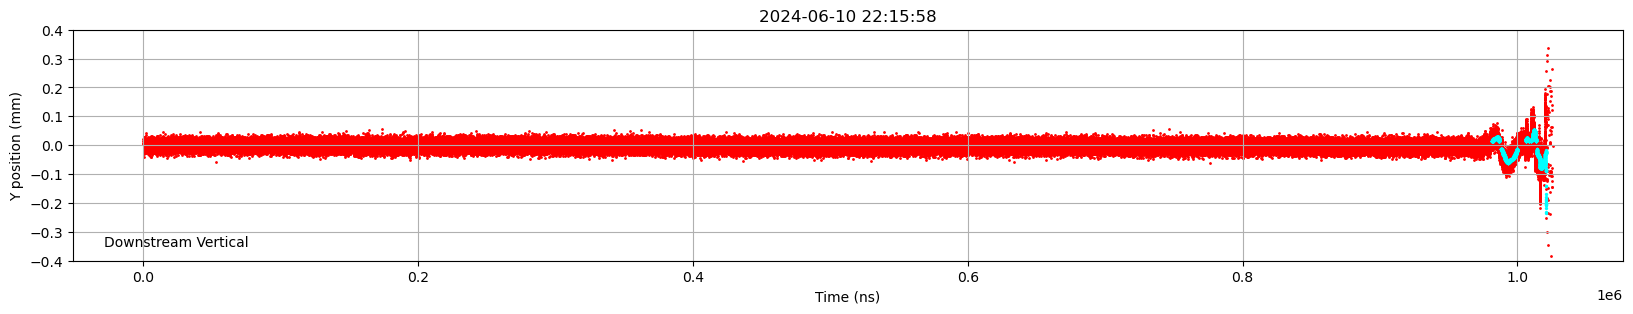

data_20240629_110237.dat
698365.4223968566


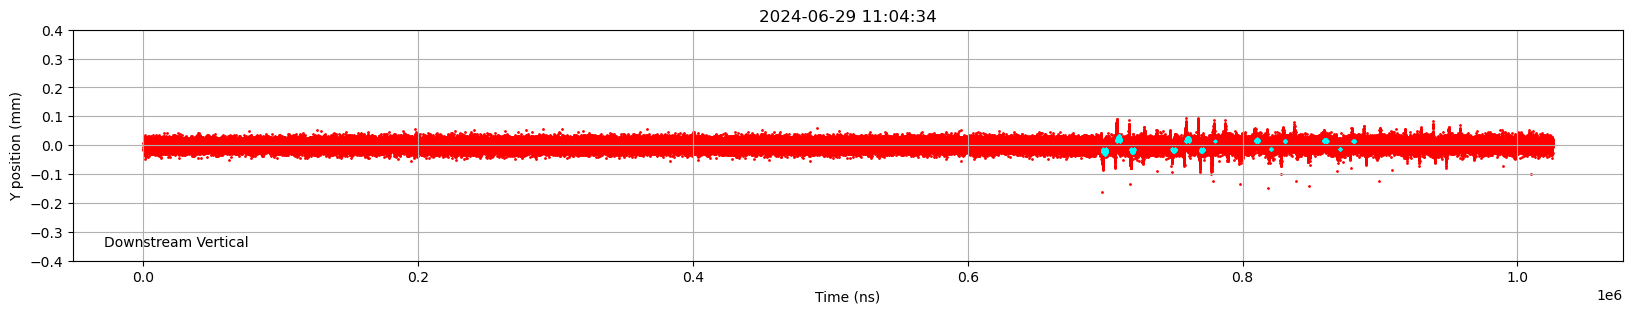

data_20240629_130456.dat
986139.489194499


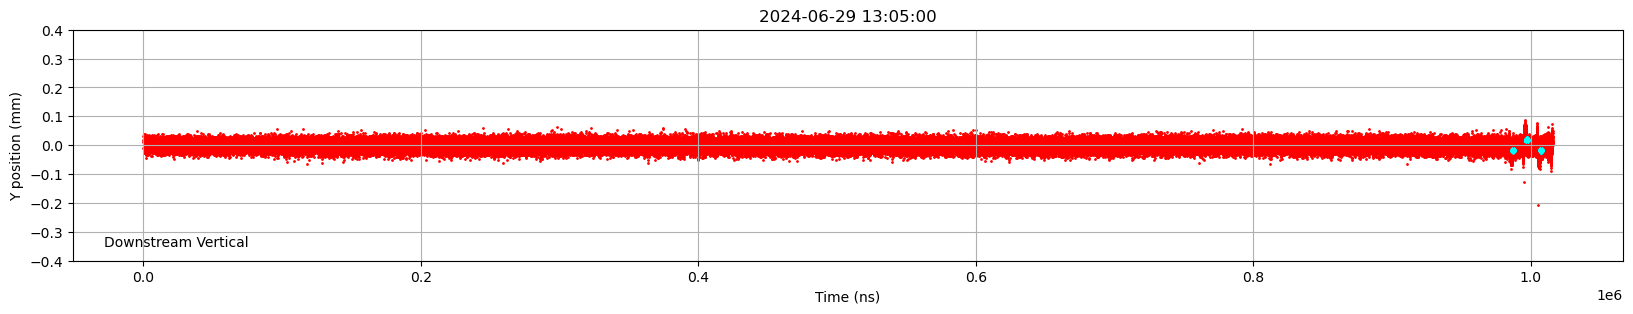

data_20240620_100200.dat
758840.8644400786


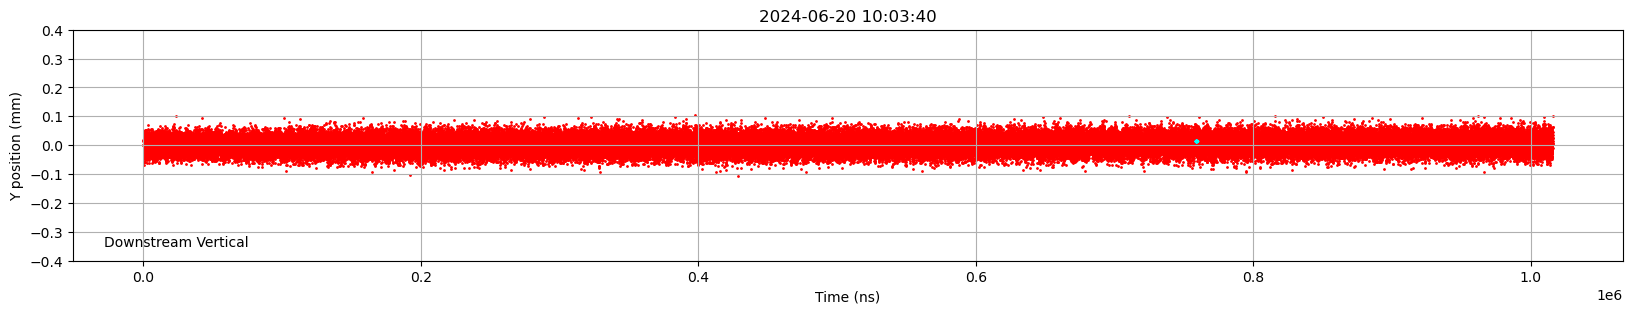

data_20240630_213815.dat
638007.8585461689


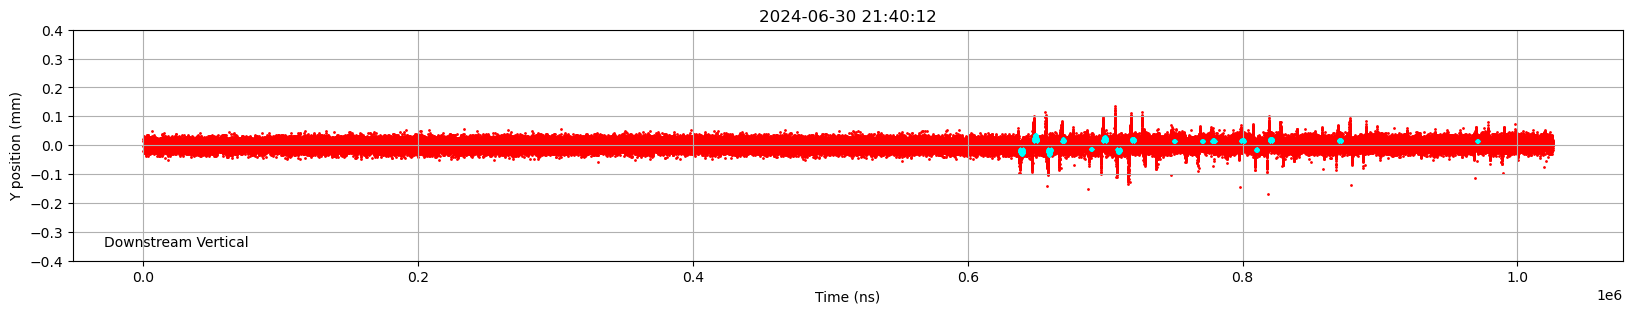

data_20240611_013323.dat
996516.699410609


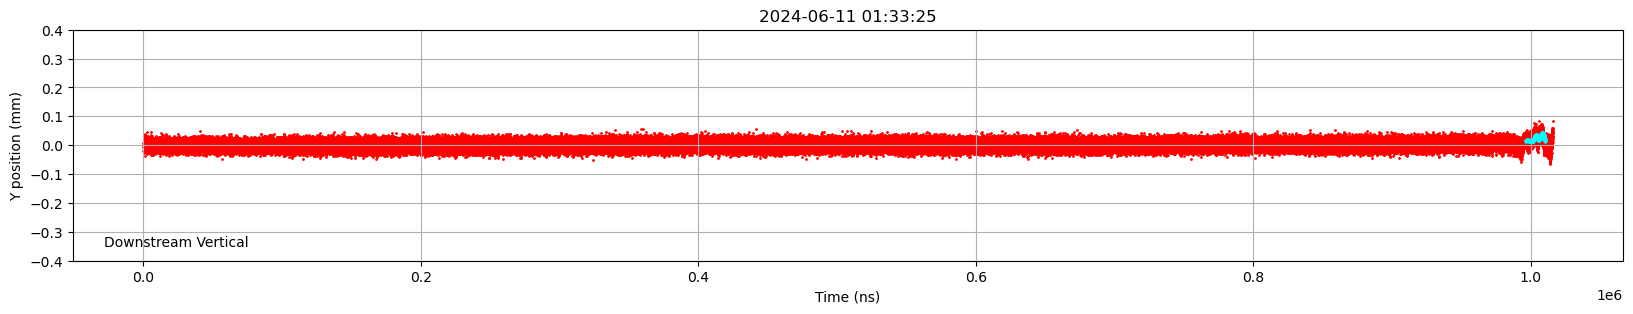

data_20240629_043535.dat
878335.9528487229


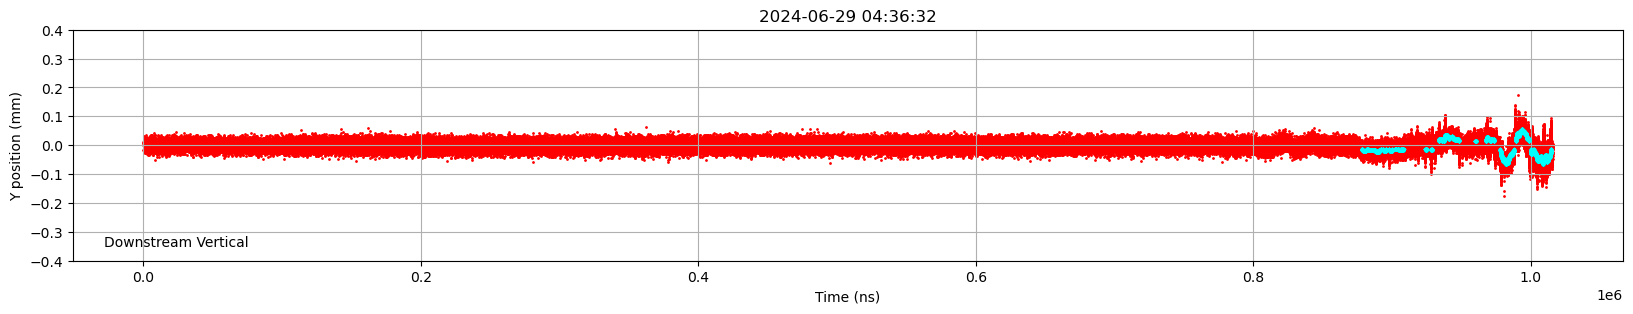

data_20240630_012656.dat
13043.222003929273


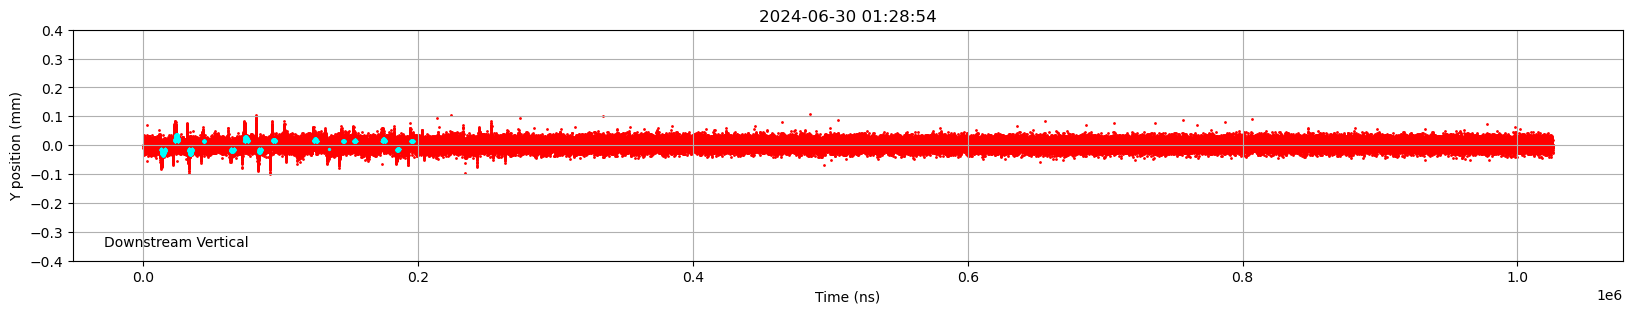

data_20240611_190642.dat
830687.6227897839


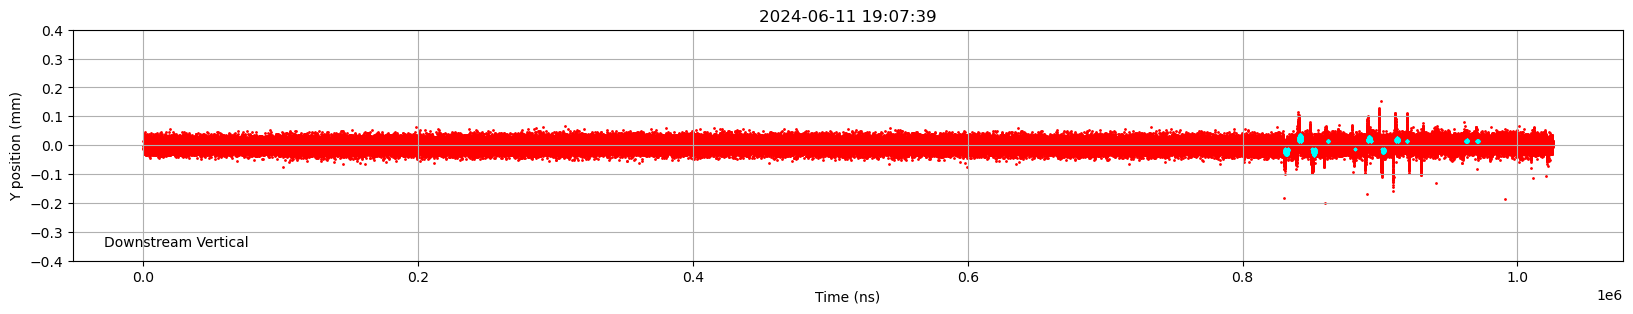

data_20240630_152716.dat
58463.654223968566


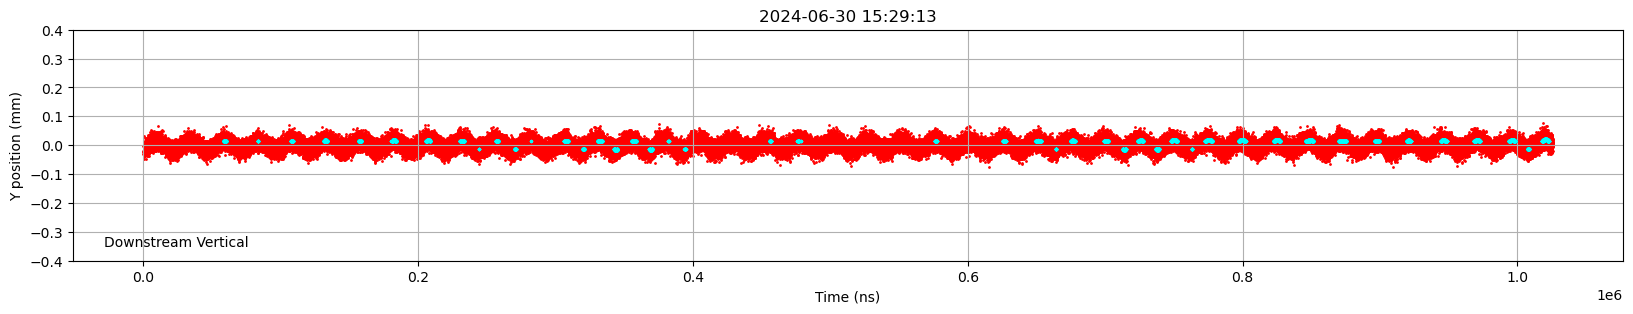

data_20240701_055133.dat
307827.1119842829


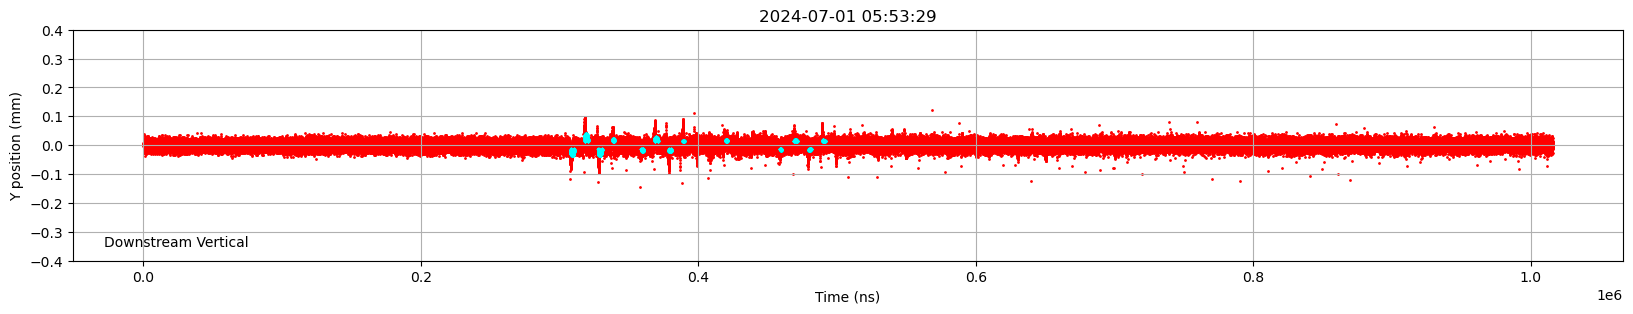

data_20240627_090855.dat
988253.4381139489


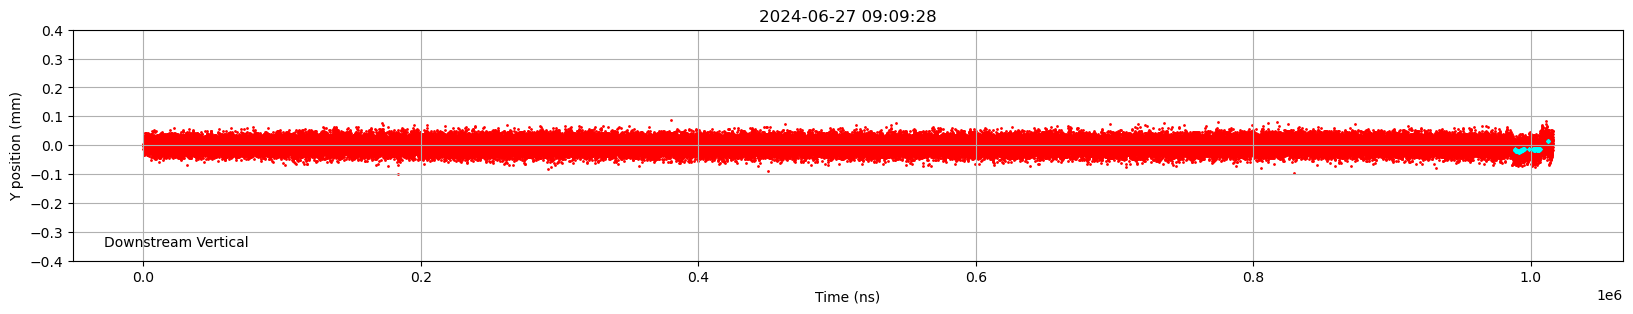

data_20240701_034113.dat
26157.170923379173


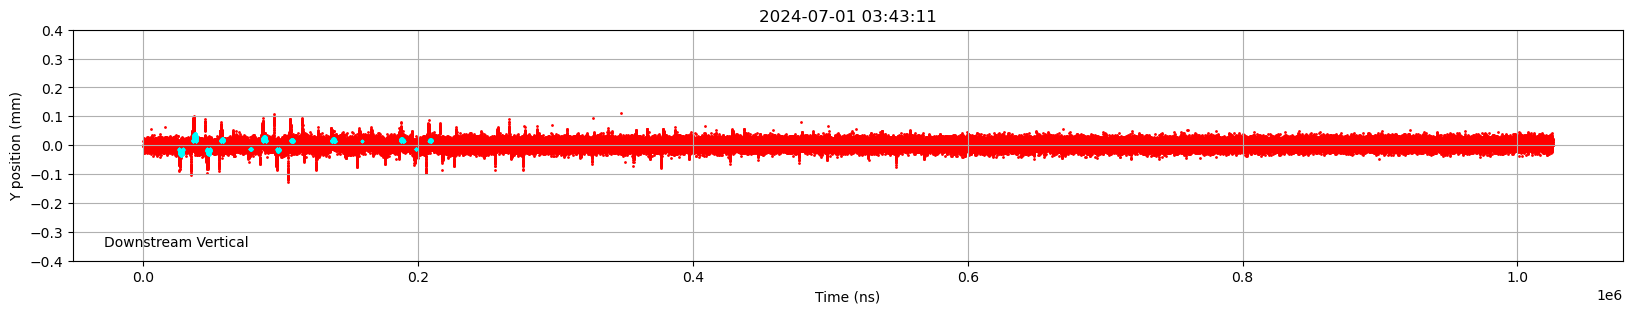

data_20240630_231831.dat
356530.45186640474


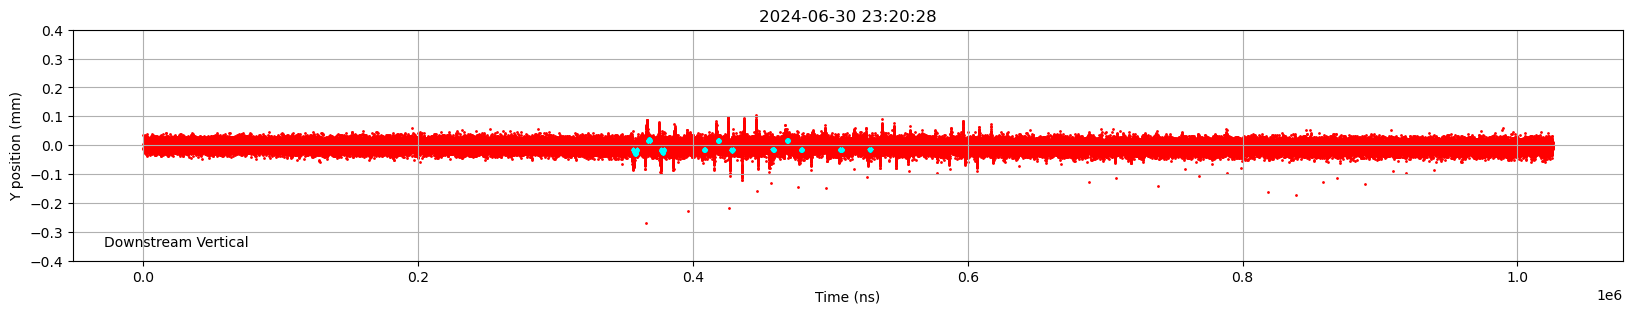

data_20240612_040813.dat
722675.8349705305


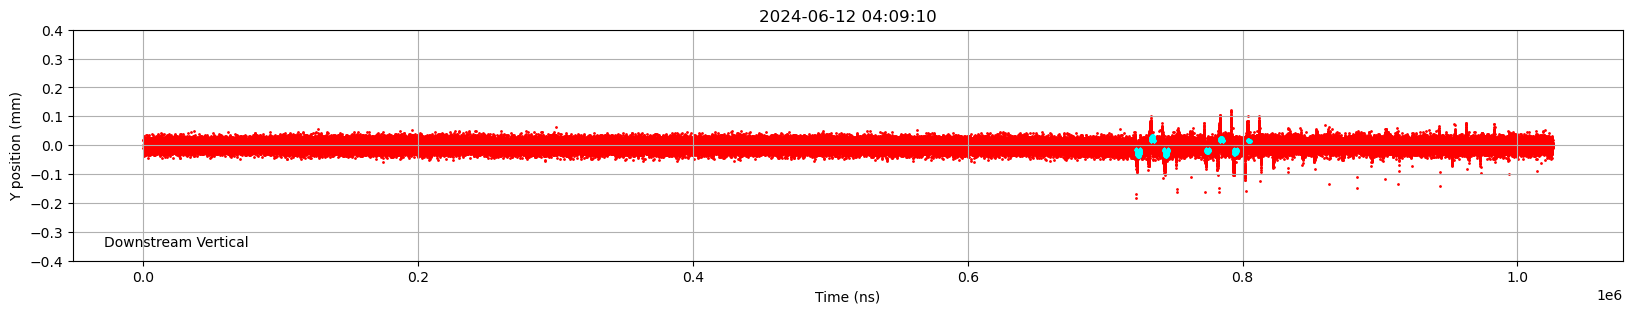

data_20240630_222623.dat
986530.4518664047


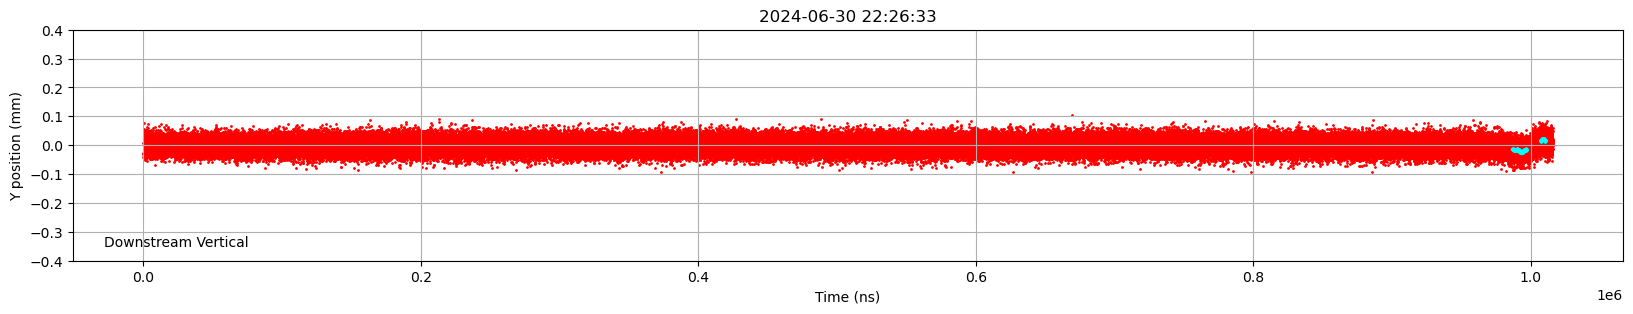

data_20240629_200003.dat
764062.8683693516


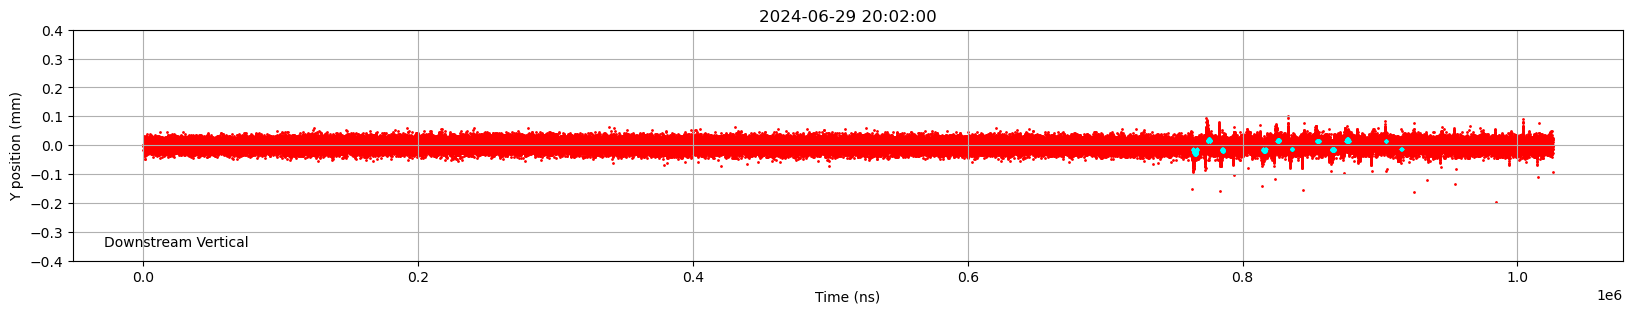

data_20240613_075246.dat
359968.56581532414


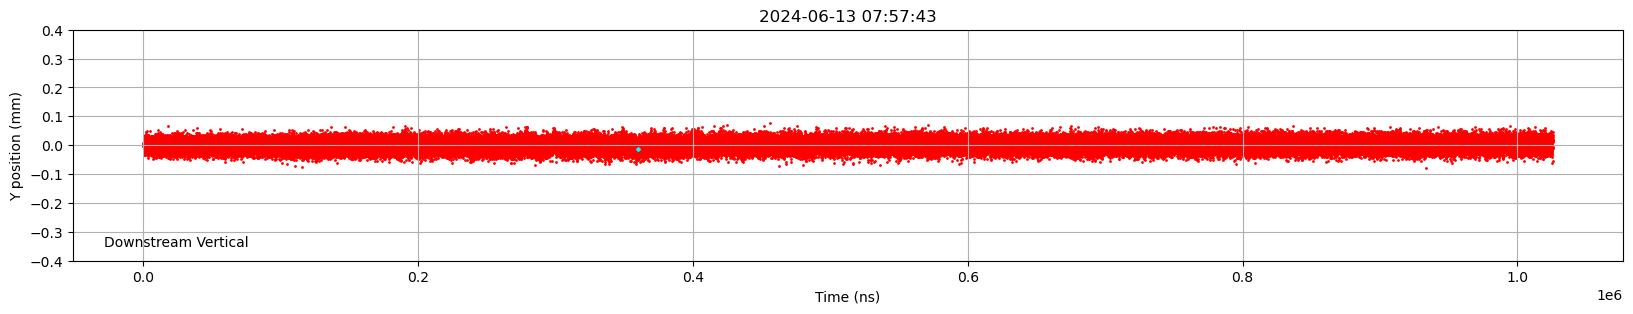

data_20240701_032911.dat
547754.42043222


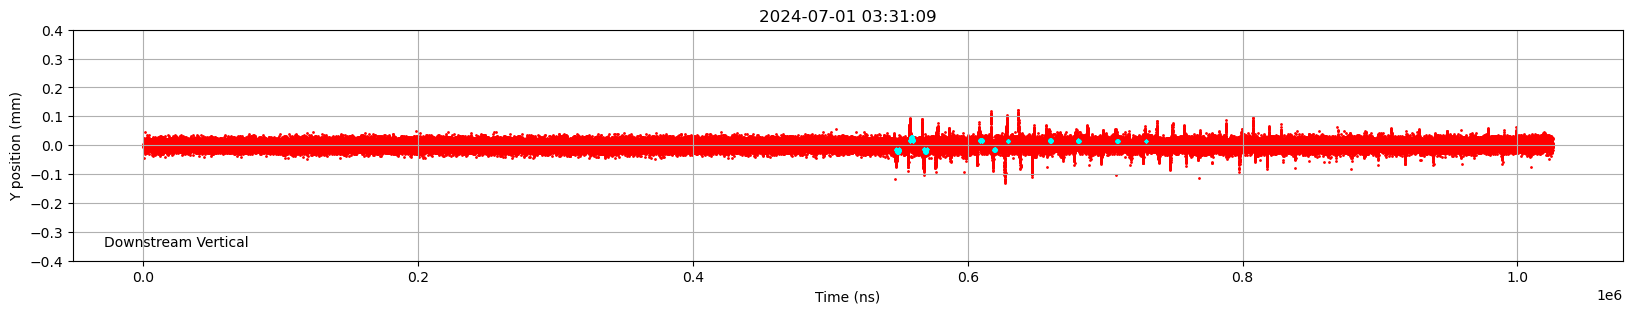

data_20240612_064056.dat
38113.948919449904


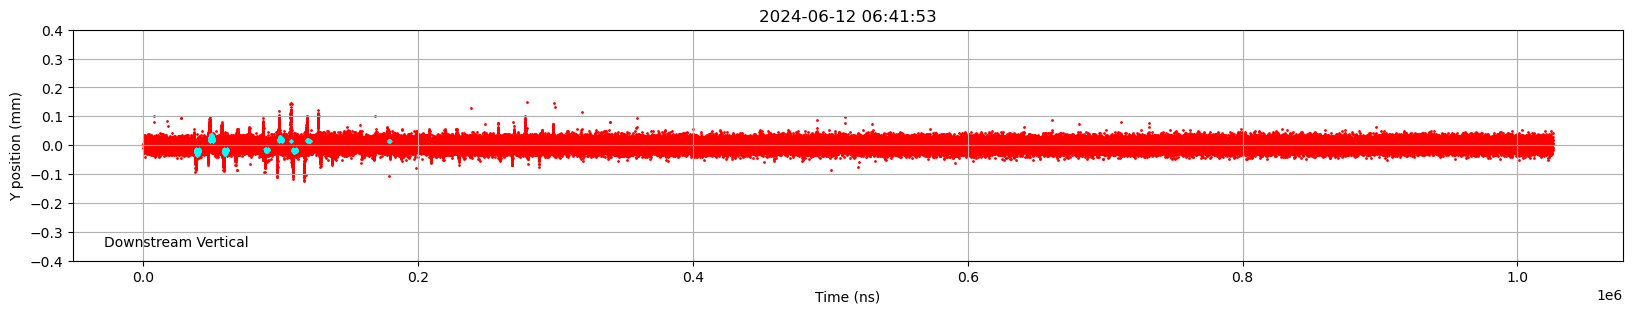

data_20240614_062944.dat
1001634.5776031434


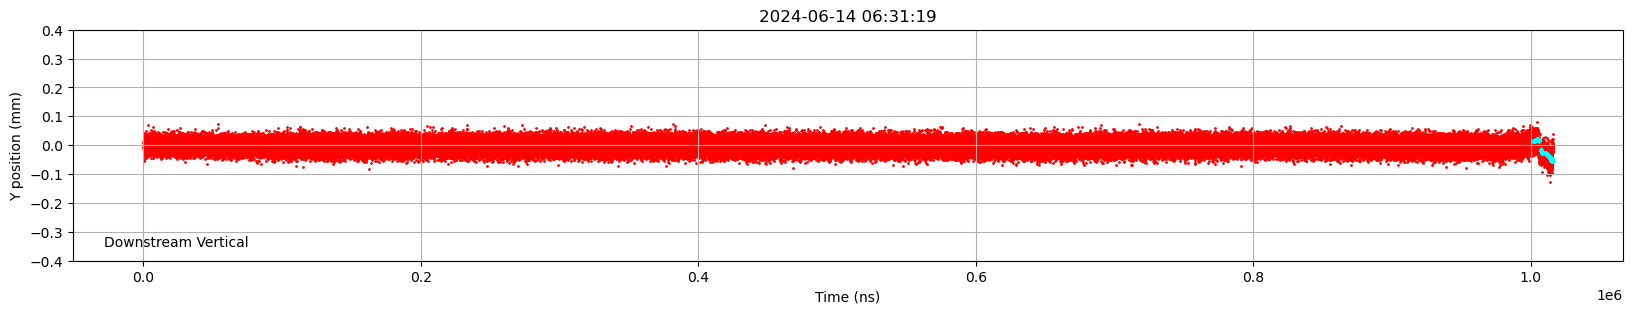

data_20240613_110300.dat
1013762.278978389


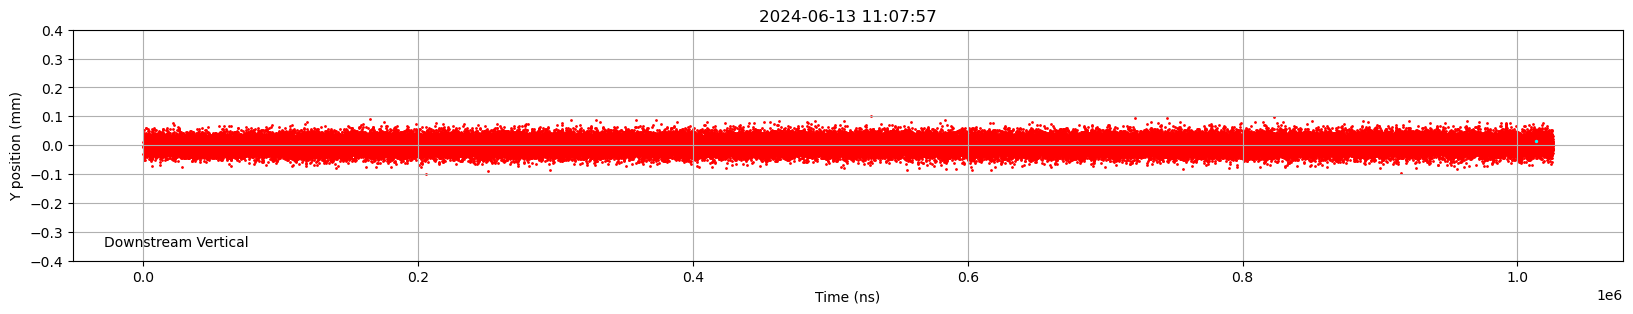

data_20240615_173756.dat
989569.7445972495


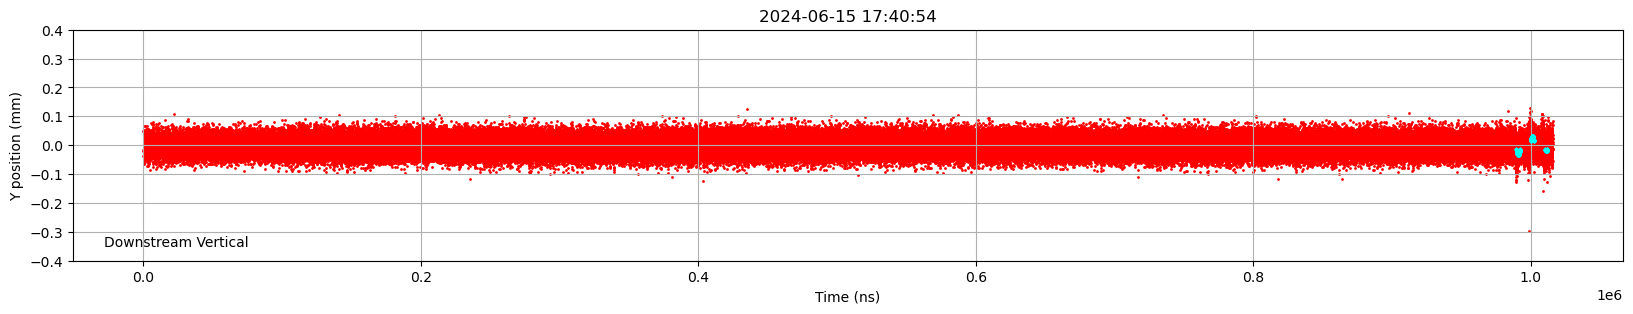

data_20240701_105820.dat
data_20240627_040207.dat
1009487.2298624754


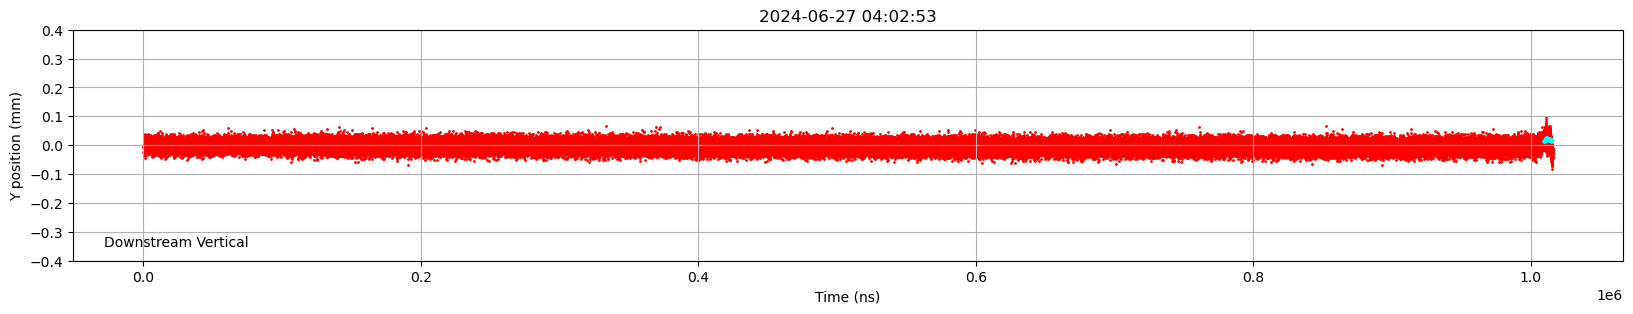

data_20240629_075606.dat
158115.91355599213


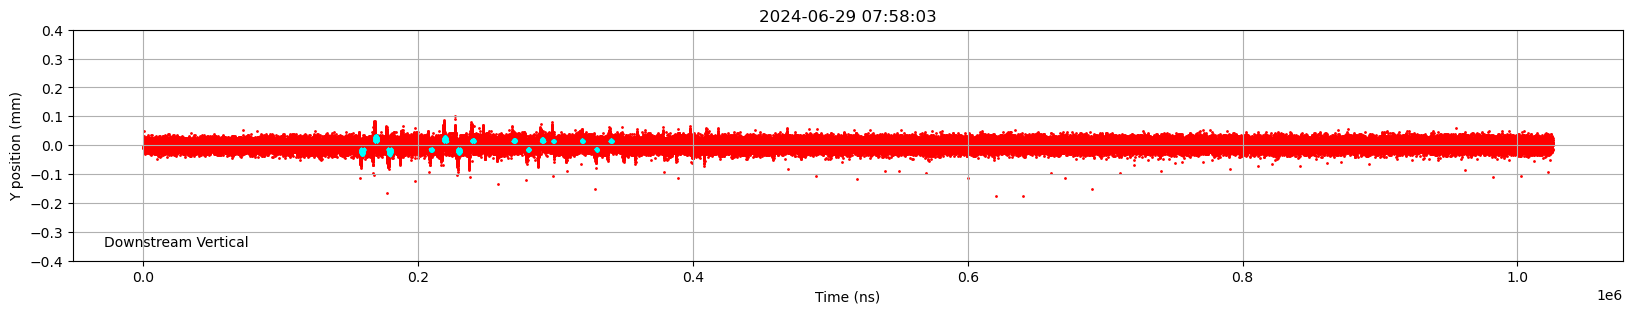

data_20240611_171008.dat
879664.047151277


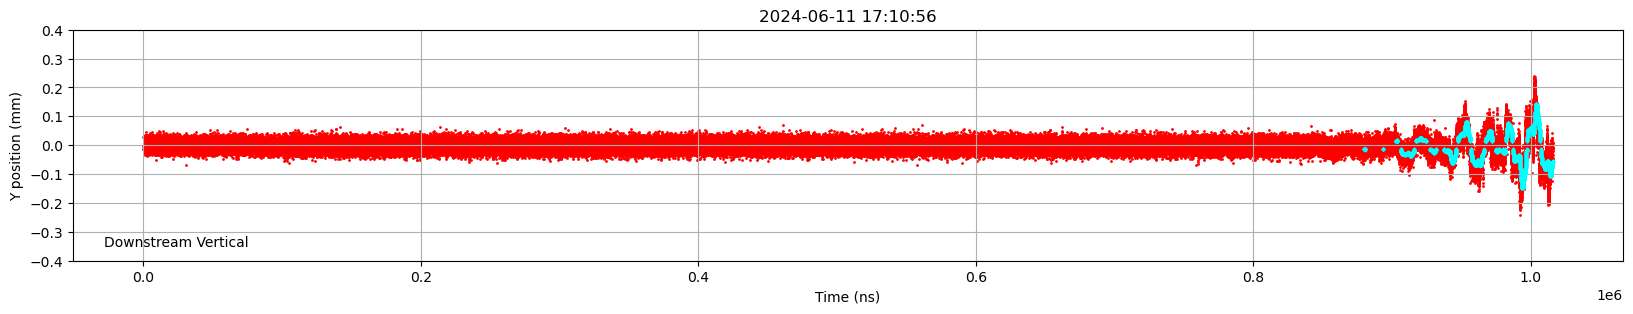

data_20240629_082009.dat
738349.7053045187


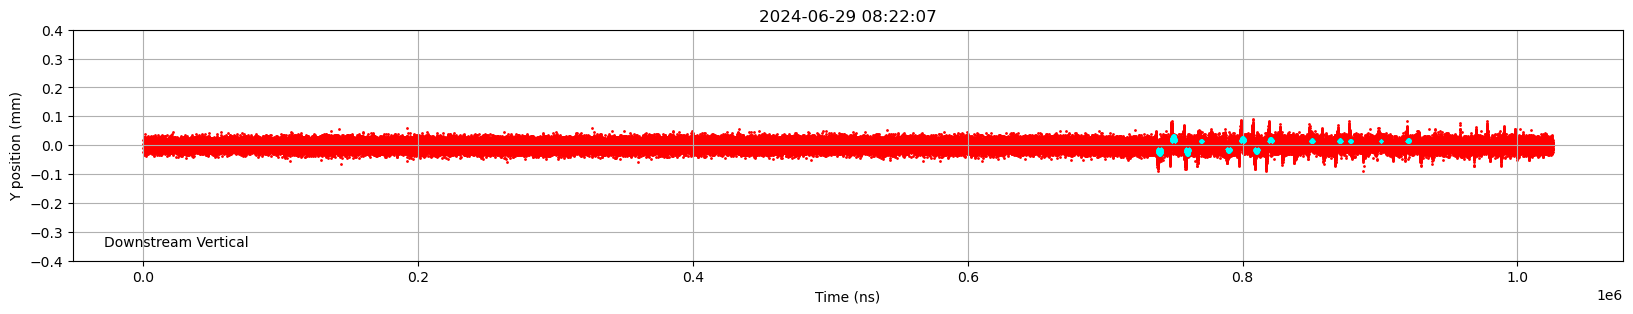

data_20240616_104921.dat
1014296.6601178782


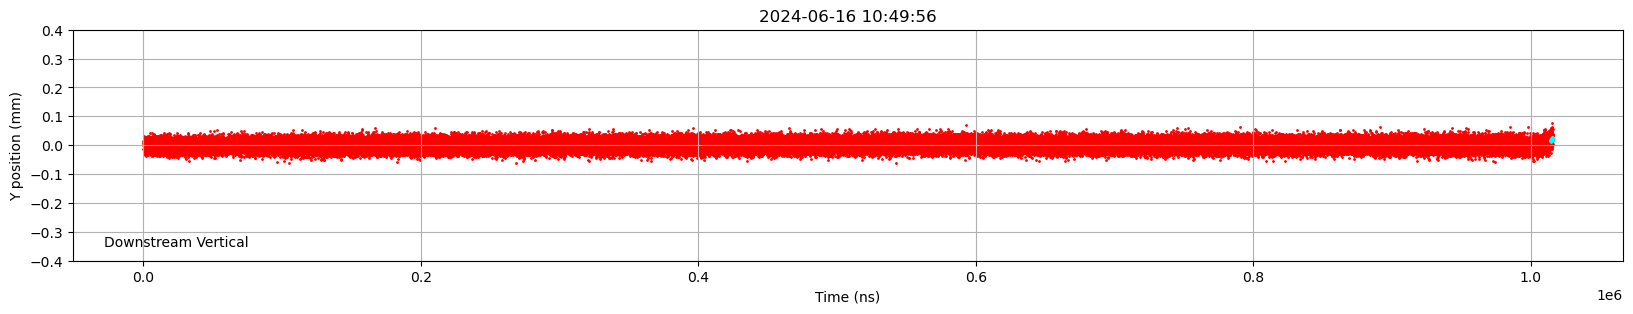

data_20240611_005610.dat
76744.59724950884


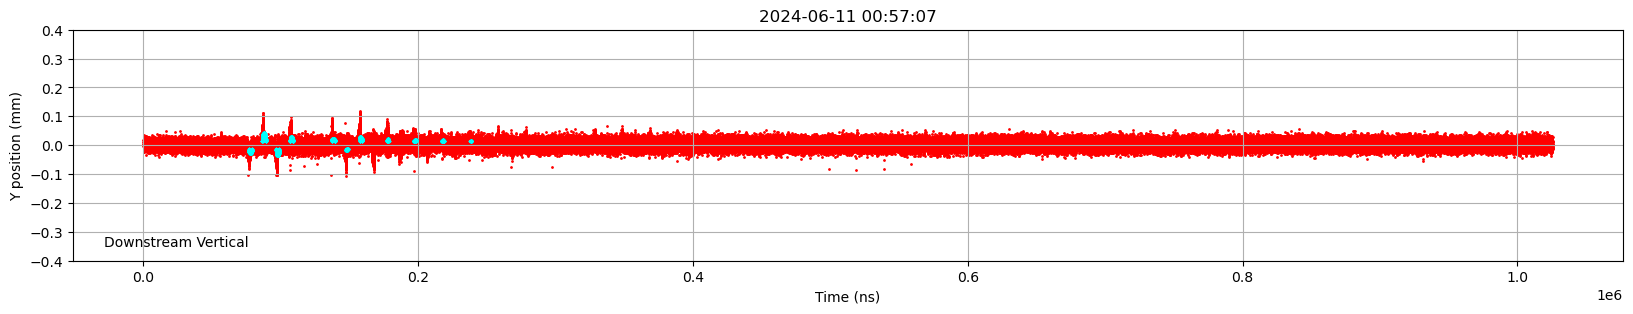

/tmp/ipykernel_2328000/3476755253.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  certain_bunch_DV.append(tbt_1/tbt_0*(16.58)/5)


data_20240610_001113.dat
910337.9174852652


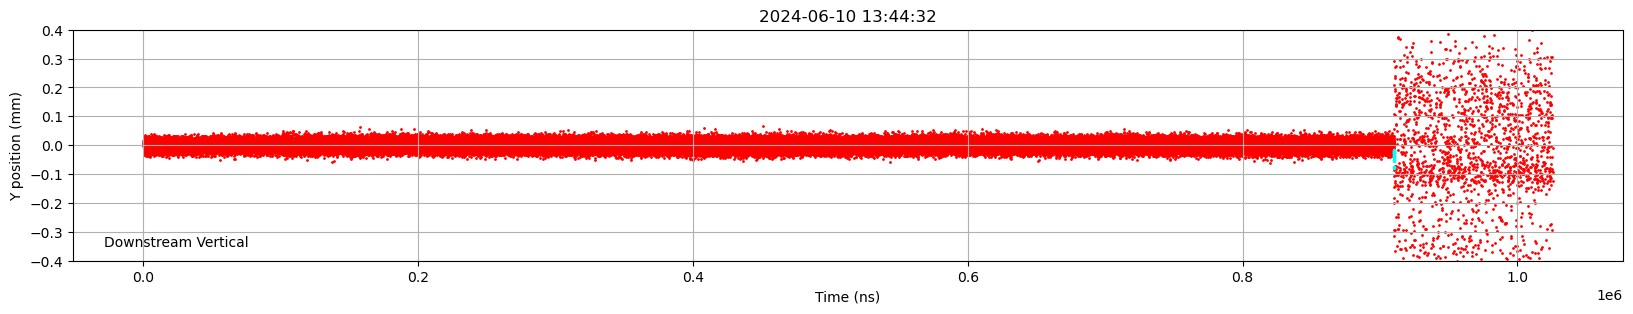

data_20240629_222227.dat
617966.601178782


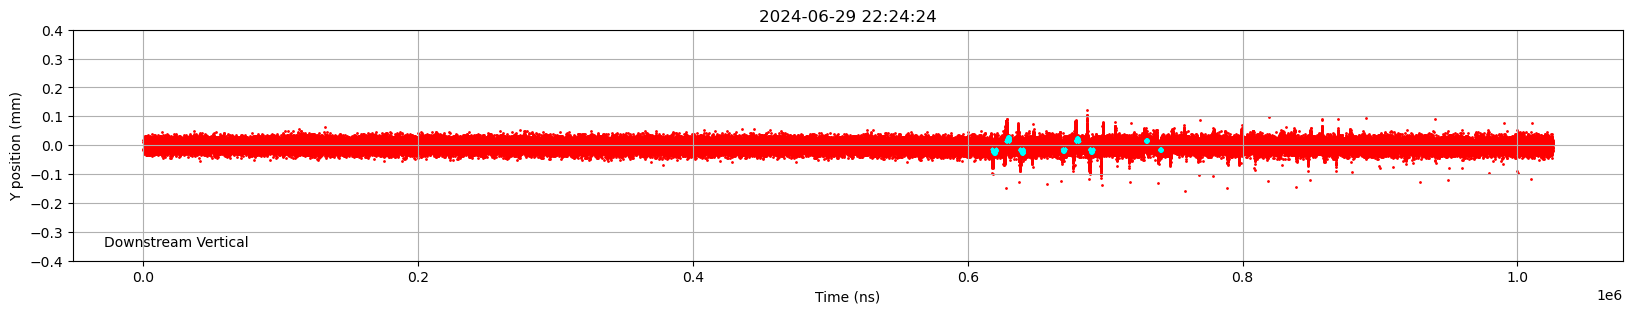

data_20240618_082253.dat
980353.6345776031


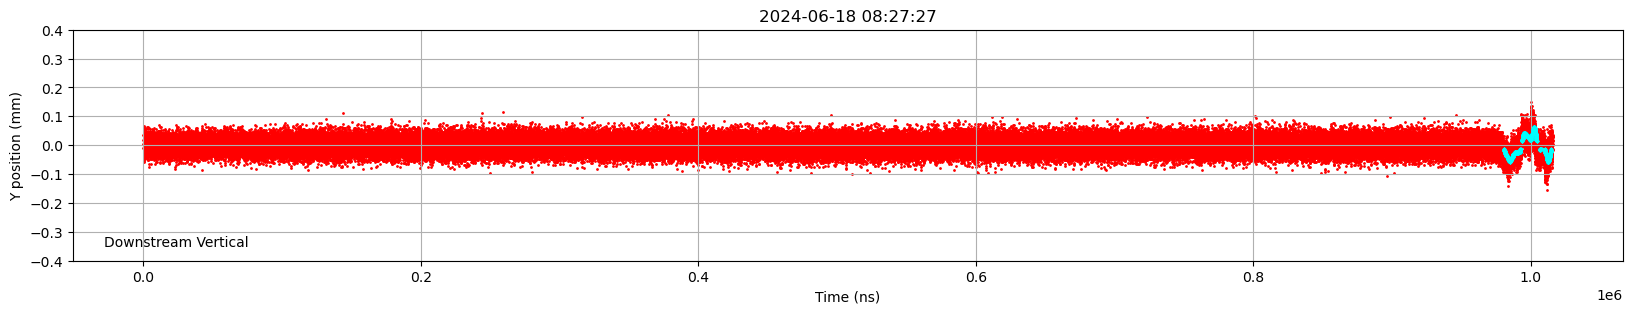

data_20240615_155249.dat
729520.6286836935


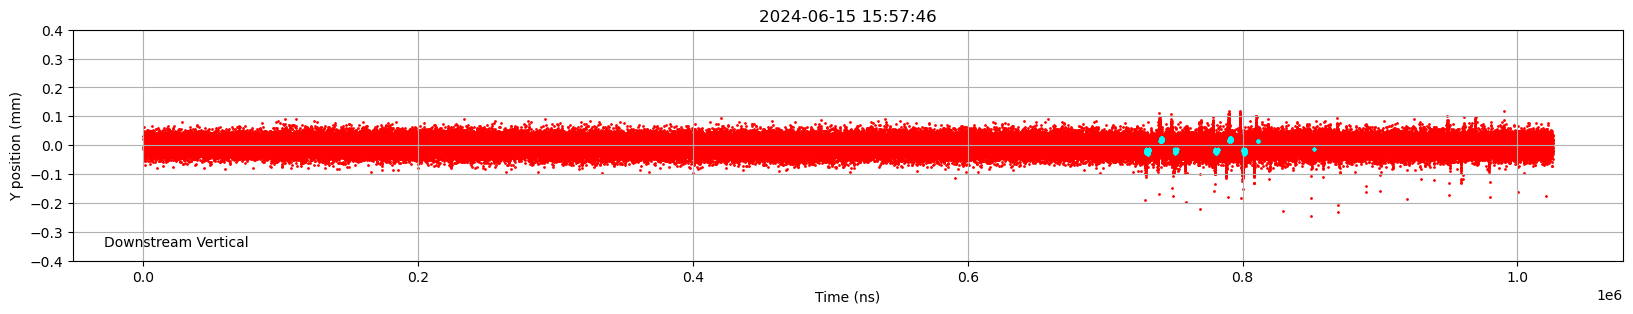

data_20240630_123449.dat
948070.7269155206


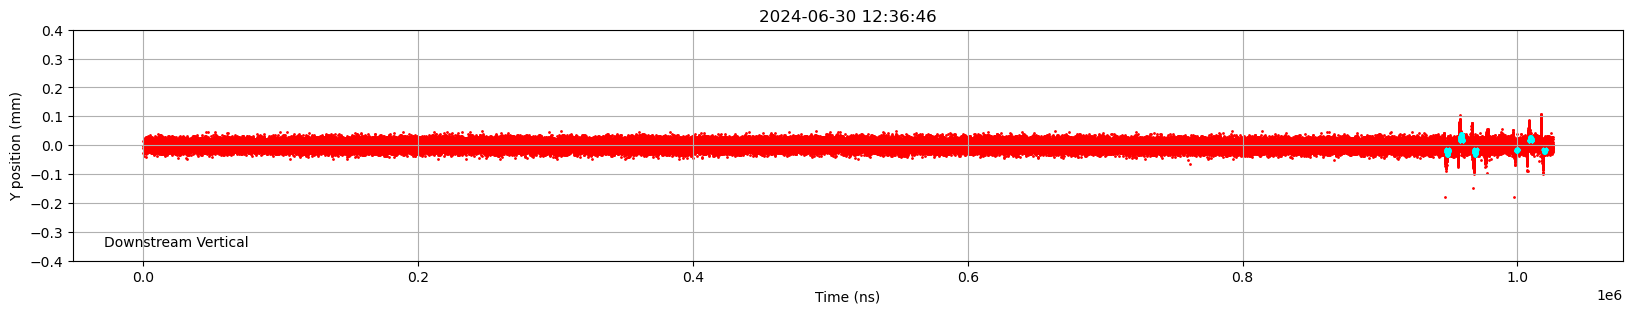

data_20240630_132057.dat
891041.2573673871


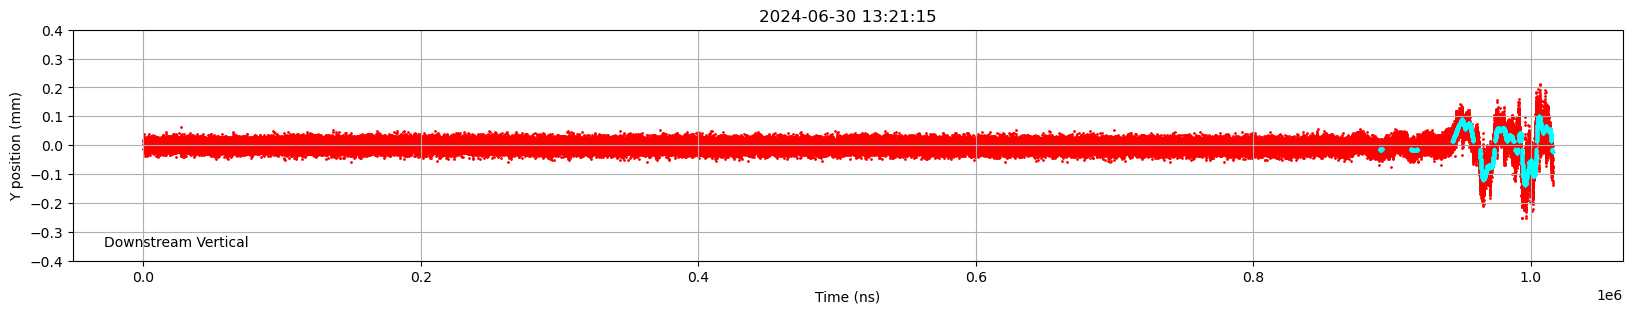

data_20240610_185008.dat
1020982.3182711198


/tmp/ipykernel_2328000/3476755253.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  certain_bunch_DV.append(tbt_1/tbt_0*(16.58)/5)


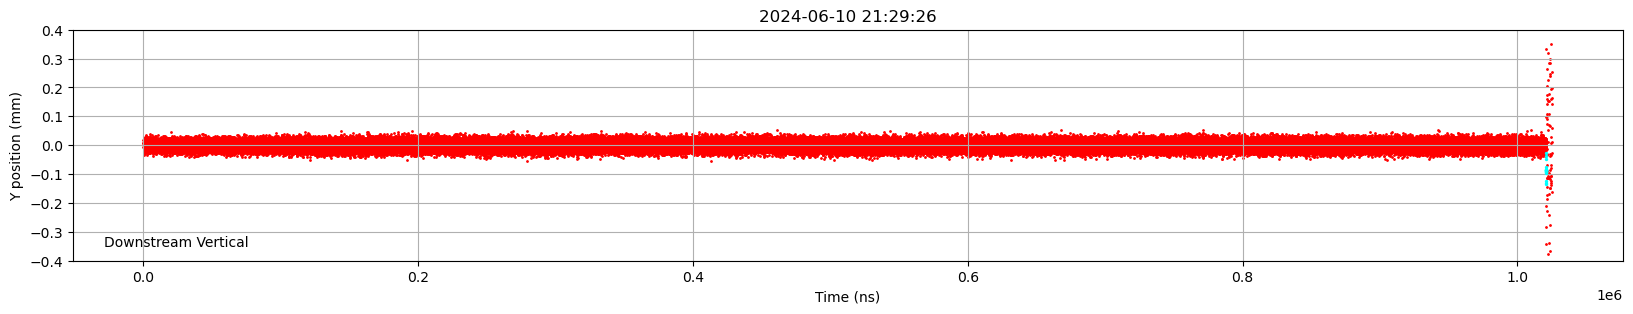

data_20240611_044226.dat
4267.190569744597


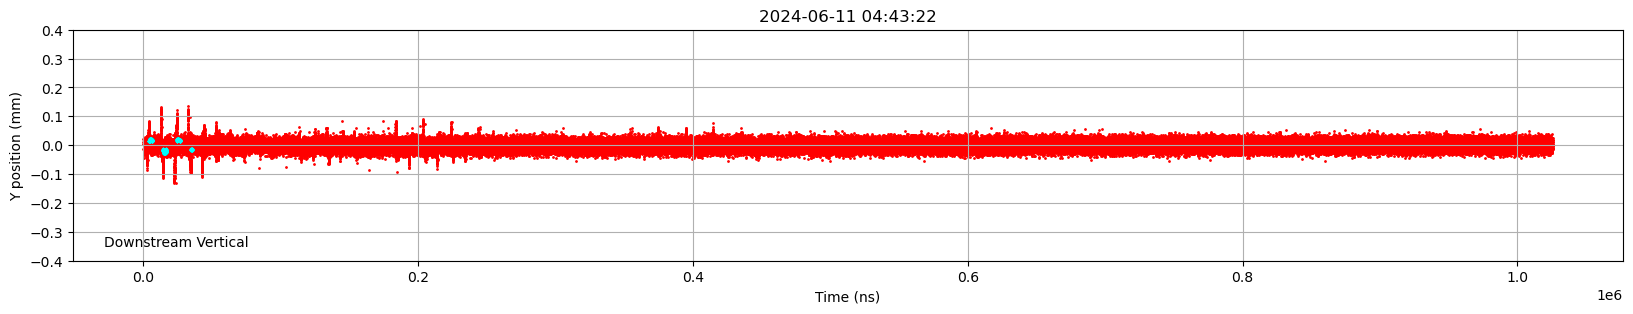

data_20240614_090455.dat
768774.0667976424


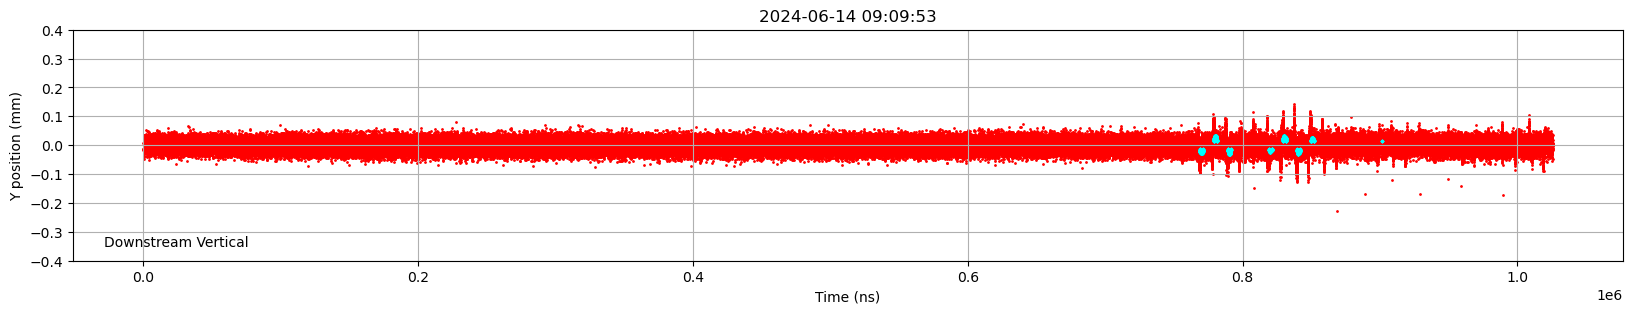

data_20240612_022545.dat
402662.08251473476


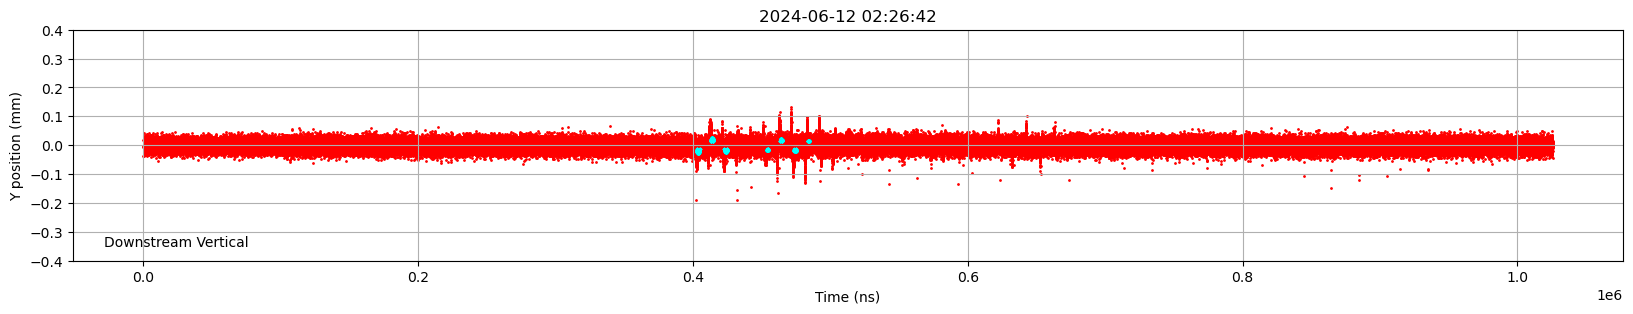

data_20240701_060334.dat
981884.0864440078


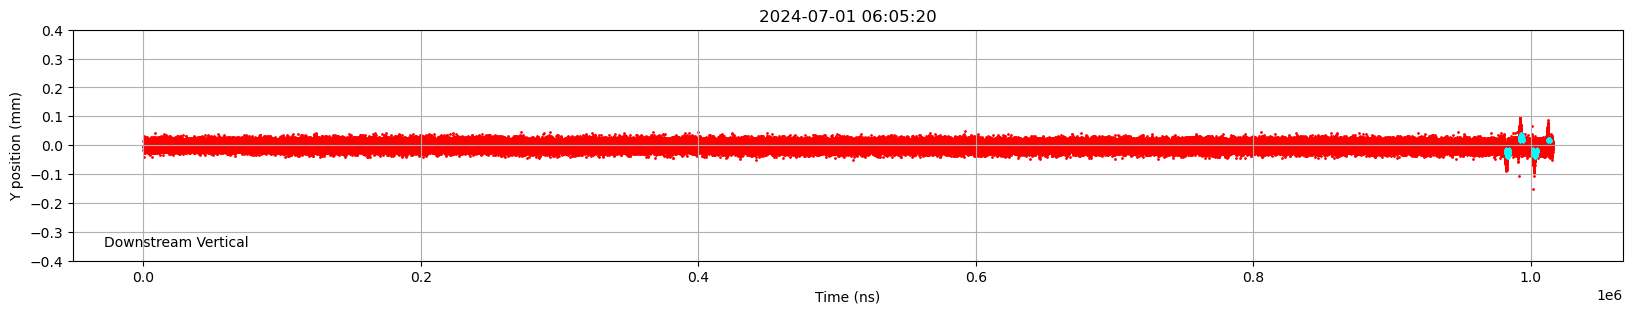

data_20240630_084211.dat
478577.60314341844


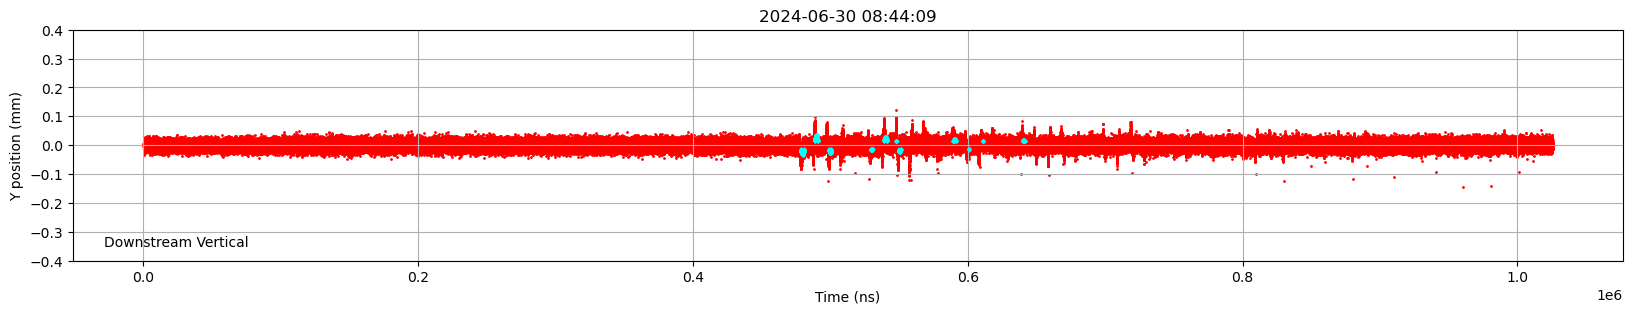

data_20240614_060442.dat
1011601.1787819254


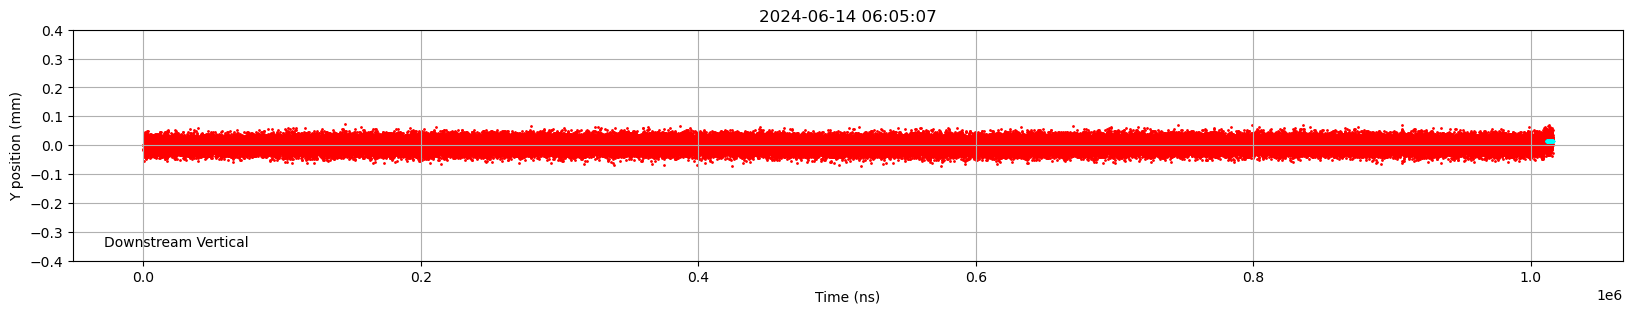

data_20240701_063338.dat
260905.6974459725


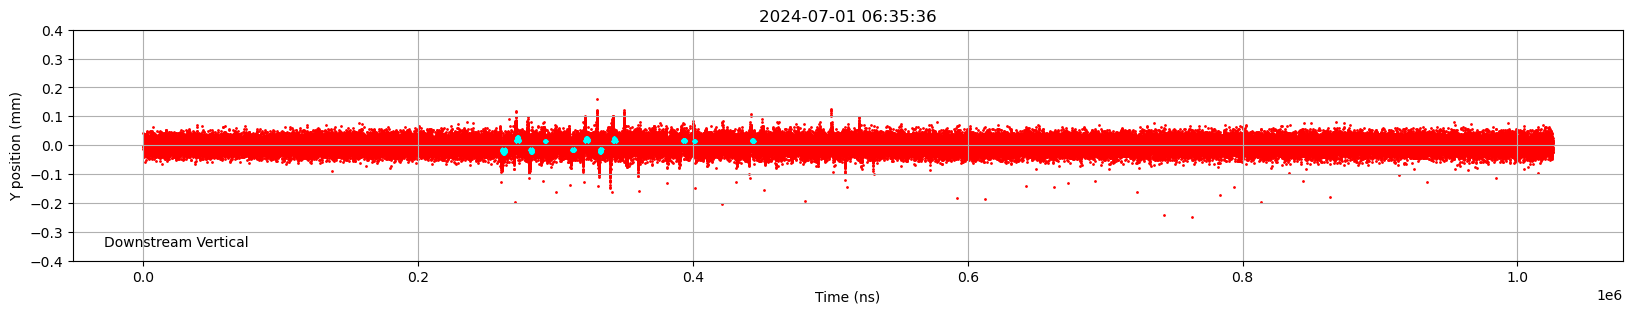

data_20240620_082551.dat
956508.8408644401


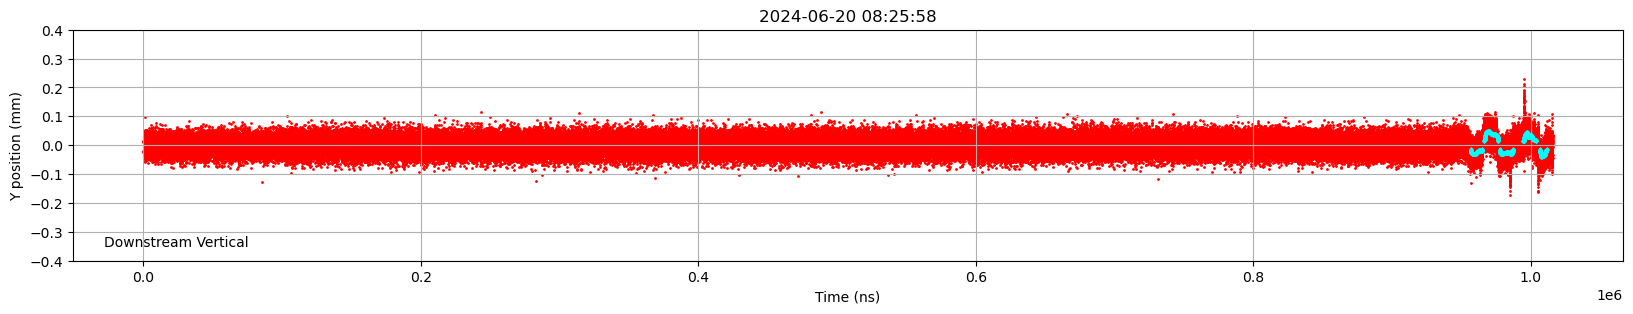

data_20240613_131810.dat
988787.8192534382


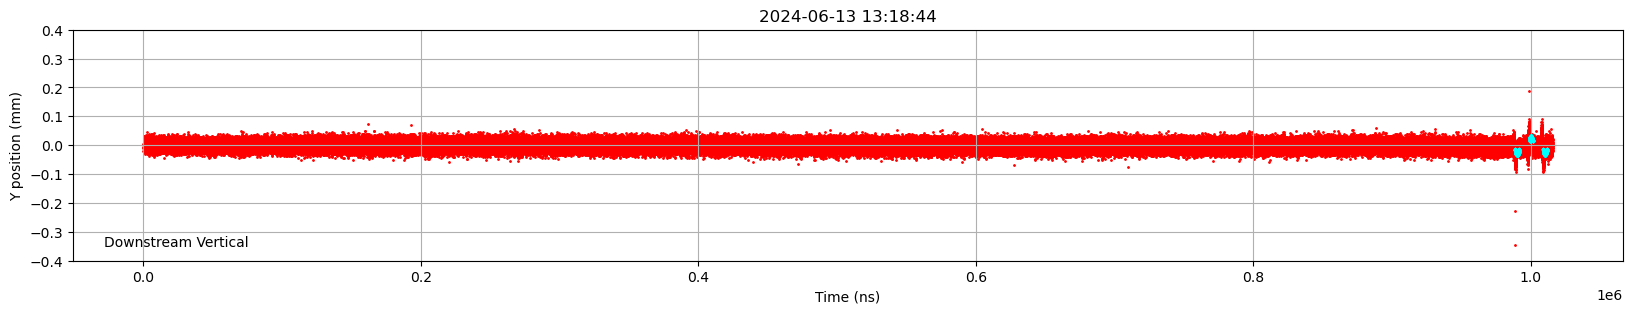

KeyboardInterrupt: 

In [7]:
counter=0
for i in dat_files:
    if periodic_plot(i)==True:
        counter+=1

In [162]:
counter

14

data_20240615_035653.dat
861269.1552062868


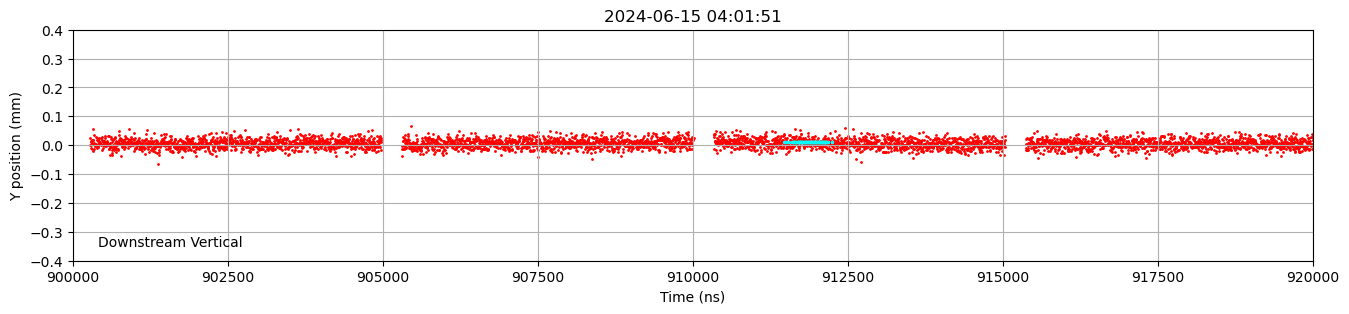

True

In [127]:
periodic_plot('data_20240615_035653.dat')

data_20240611_171008.dat
data_20240611_171008.dat


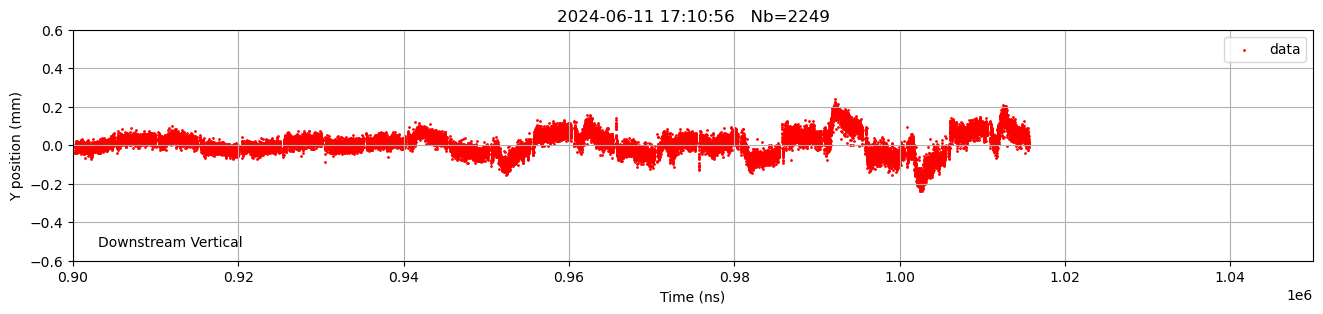

True

In [44]:
periodic_plot('data_20240611_171008.dat')

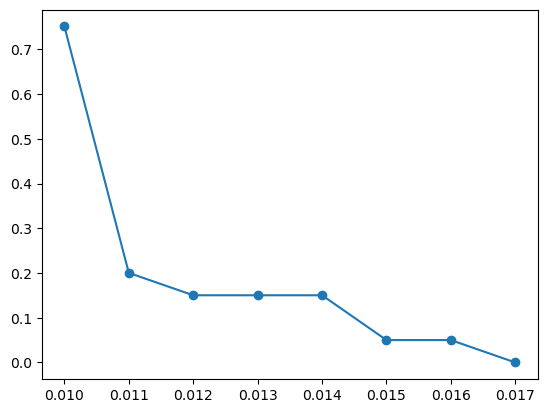

In [168]:
plt.plot([0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017],np.array([15,4,3,3,3,1,1,0])/1997*100,marker='o')